# Проект: промышленность - предсказательная модель температуры расплавленного состояния сплава

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

**Задача** — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
* `data_arc_new.csv` — данные об электродах;
* `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
* `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
* `data_gas_new.csv` — данные о продувке сплава газом;
* `data_temp_new.csv` — результаты измерения температуры;
* `data_wire_new.csv` — данные о проволочных материалах (объём);
* `data_wire_time_new.csv` — данные о проволочных материалах (время).

Файл `data_arc_new.csv`
* `key` — номер партии;
* `Начало нагрева дугой` — время начала нагрева;
* `Конец нагрева дугой` — время окончания нагрева;
* `Активная мощность` — значение активной мощности;
* `Реактивная мощность` — значение реактивной мощности.

Файл `data_bulk_new.csv`
* `key` — номер партии;
* `Bulk 1 … Bulk 15` — объём подаваемого материала.

Файл `data_bulk_time_new.csv`
* `key` — номер партии;
* `Bulk 1 … Bulk 15` — время подачи материала.

Файл `data_gas_new.csv`
* `key` — номер партии;
* `Газ 1` — объём подаваемого газа.

Файл `data_temp_new.csv`
* `key` — номер партии;
* `Время замера` — время замера;
* `Температура` — значение температуры.

Файл `data_wire_new.csv`
* `key` — номер партии;
* `Wire 1 … Wire 9` — объём подаваемых проволочных материалов.

Файл `data_wire_time_new.csv`
* `key` — номер партии;
* `Wire 1 … Wire 9` — время подачи проволочных материалов.

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**План работы**

**1. Загрузка данных**

Загрузим данные и выполним их первичный осмотр.

**2. Исследовательский анализ и предобработка данных**

Выполним исследовательский анализ каждого датафрейма и при необходимости выполним предобработку. Сделаем выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

**3. Объединение данных**

Объединим выбранные нами признаки в один датафрейм по ключу.

**4. Исследовательский анализ и предобработка данных объединённого датафрейма**

Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков и при необходимости выполним предобработку. Проведем корреляционный анализ. При необходимости сгенерируем новые признаки.

**5. Подготовка данных**

Выполним подготовку данных для обучения модели. Разделим данные на две выборки, при масштабировании и кодировании учитем особенности данных и моделей.

**6. Обучение моделей машинного обучения**

Обучим как минимум две модели. Хотя бы для одной из них подберем как минимум два гиперпараметра.

**7. Выбор лучшей модели**

Выберем лучшую модель и проверим её качество на тестовой выборке.

**8. Общий вывод и рекомендации заказчику**

## 1. Загрузка данных

In [9]:
!pip install phik -q

In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from functools import reduce
from phik import report 
from phik.report import plot_correlation_matrix
from functools import reduce
from catboost import Pool

In [11]:
warnings.filterwarnings('ignore')

In [12]:
# загружаем данные
try:
    data_arc       = pd.read_csv('data_arc_new.csv')
    data_bulk      = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas       = pd.read_csv('data_gas_new.csv')
    data_temp      = pd.read_csv('data_temp_new.csv')
    data_wire      = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')
except:
    data_arc       = pd.read_csv('datasets/data_arc_new.csv')
    data_bulk      = pd.read_csv('datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('datasets/data_bulk_time_new.csv')
    data_gas       = pd.read_csv('datasets/data_gas_new.csv')
    data_temp      = pd.read_csv('datasets/data_temp_new.csv')
    data_wire      = pd.read_csv('datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('datasets/data_wire_time_new.csv')

In [14]:
# функция для описания датафрейма
def df_describe(df, name='DataFram'):
    print(f'Анализ: {name}')
    print(f'Размерность: {df.shape[0]} строк × {df.shape[1]} столбцов\n')
    
    print('Первые 10 строк:')
    display(df.head(10))
    
    print('Общая информация:')
    df.info()
    
    print('\nСтатистическое описание:')
    display(df.describe())
    
    print('\nПропущенные значения (по столбцам):')
    df.isna().sum()
    display(df.isna().sum())

    print('\nКоличество явных дубликатов:')
    display(df.duplicated().sum())

pd.set_option('display.max_columns', None)

In [15]:
# отображаяем данные из всез датафреймов
all_data = {
    'data_arc': data_arc,
    'data_bulk': data_bulk,
    'data_bulk_time': data_bulk_time,
    'data_gas': data_gas,
    'data_temp': data_temp,
    'data_wire': data_wire,
    'data_wire_time': data_wire_time,
}

for name, data in all_data.items():
    print('='*80)
    df_describe(data, name)

Анализ: data_arc
Размерность: 14876 строк × 5 столбцов

Первые 10 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Статистическое описание:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Пропущенные значения (по столбцам):


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


Количество явных дубликатов:


0

Анализ: data_bulk
Размерность: 3129 строк × 16 столбцов

Первые 10 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB

Статистическое описание:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Пропущенные значения (по столбцам):


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


Количество явных дубликатов:


0

Анализ: data_bulk_time
Размерность: 3129 строк × 16 столбцов

Первые 10 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB

Статистическое описание:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Пропущенные значения (по столбцам):


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


Количество явных дубликатов:


0

Анализ: data_gas
Размерность: 3239 строк × 2 столбцов

Первые 10 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Статистическое описание:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Пропущенные значения (по столбцам):


key      0
Газ 1    0
dtype: int64


Количество явных дубликатов:


0

Анализ: data_temp
Размерность: 18092 строк × 3 столбцов

Первые 10 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

Статистическое описание:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



Пропущенные значения (по столбцам):


key                0
Время замера       0
Температура     3427
dtype: int64


Количество явных дубликатов:


0

Анализ: data_wire
Размерность: 3081 строк × 10 столбцов

Первые 10 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Статистическое описание:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Пропущенные значения (по столбцам):


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Количество явных дубликатов:


0

Анализ: data_wire_time
Размерность: 3081 строк × 10 столбцов

Первые 10 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Статистическое описание:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Пропущенные значения (по столбцам):


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


Количество явных дубликатов:


0

**Вывод:** 

Данные были загружены и произведена первичная оценка:
* data_arc - размер: 14 876 строк × 5 столбцов. Данные полные, без пропусков и дубликатов. Все временные данные — строкового формата, нуждаются в преобразовании в datetime для анализа продолжительности. Средняя активная мощность — 0.66, реактивная — 0.44. Есть выброс в реактивной мощности: минимум — -715, что требует проверки.
* data_bulk - размер: 3 129 строк × 16 столбцов. Много пропущенных значений по отдельным компонентам (особенно Bulk 2, Bulk 8, Bulk 13 и др.). Варьируются дозировки — от 1 до 1 849 кг. Требуется работа с пропущенными значениями - заполнение нулями (отсутсвие добавки).
* data_bulk_time - размер: 3 129 строк × 16 столбцов. Пропуски аналогичны data_bulk — те же позиции часто пустуют. Все значения строкового типа, необходимо преобразование в datetime. Временные данные можно использовать для расчета задержек или упорядочивания подачи при синхронизации с data_bulk и data_arc по key.
* data_gas - размер: 3239 строк × 2 столбца. Пропусков нет. 
* data_temp - размер: 18092 строк × 3 столбца. Наблюдается 3427 пропусков. Временная метку стоит преобразовать в datetime.
* data_wire - размер: 3081 строк × 10 столбцов. Много проусков в данных, в основном заполнена только Wire 1. Требуется дополнительное изучение для работы с пропусками. 
* data_wire_time  - размер: 3081 строк × 10 столбцов. Также большое количество пропумсков аналогичное датафрейму data_wire. Требуется преобразование в datetime.

## 2. Исследовательский анализ данных и предобработка данных

### data_arc

Переименуем столбцы для соответсвия PEP 8.

In [21]:
# переименовываем столбцы
data_arc.columns = ['key', 'start_arc_heating', 'end_arc_heating', 'active_power', 'reactive_power']

# проверяем
data_arc.columns

Index(['key', 'start_arc_heating', 'end_arc_heating', 'active_power',
       'reactive_power'],
      dtype='object')

In [22]:
# меняем формат столбцов на datetime
data_arc['start_arc_heating'] = pd.to_datetime(data_arc['start_arc_heating'])
data_arc['end_arc_heating'] = pd.to_datetime(data_arc['end_arc_heating'])

# проверяем
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   start_arc_heating  14876 non-null  datetime64[ns]
 2   end_arc_heating    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


При первичном ознакомлении с данными были выявлены выбросы в реактивной мощности (минимум — -715). Удалим подобные строки. 

In [24]:
# найдём все ковшы, где reactive_power ≤ 0 хотя бы в одной строке
low_power_keys = data_arc.loc[data_arc['reactive_power'] <= 0, 'key'].unique()
print(f"Будут удалены ковши (key): {low_power_keys}")
print(f"Число ковшей c reactive_power ≤ 0: {len(low_power_keys)}")

# удалим все строки, относящиеся к этим кейсам
data_arc = data_arc[~data_arc['key'].isin(low_power_keys)]

Будут удалены ковши (key): [2116]
Число ковшей c reactive_power ≤ 0: 1


Добавим новые признаки - продолжительность нагрева дуги, активная энергия, реактивная энергия, полная мощность, полная энергия. Удаляем столбцы со временем, так они больше неинформативны.

In [29]:
# продолжительность нагрева в секундах
data_arc['arc_duration_sec'] = (data_arc['end_arc_heating'] - data_arc['start_arc_heating']).dt.total_seconds()

# полная мощность = квадратный корень(активная мощность ** 2 + реактивная мощность**2)
data_arc['full_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

# энергия = мощность * время
data_arc['active_energy'] = data_arc['active_power'] * data_arc['arc_duration_sec']
data_arc['reactive_energy'] = data_arc['reactive_power'] * data_arc['arc_duration_sec']
data_arc['full_energy'] = data_arc['full_power'] * data_arc['arc_duration_sec']

# удаляем столбцы со временем 
data_arc = data_arc.drop(['start_arc_heating', 'end_arc_heating'], axis=1)

In [30]:
data_arc

,key,active_power,reactive_power,arc_duration_sec,full_power,active_energy,reactive_energy,full_energy
0,1,0.305130,0.211253,228.0,0.371123,69.569640,48.165684,84.616003
1,1,0.765658,0.477438,185.0,0.902319,141.646730,88.326030,166.928978
2,1,0.580313,0.430460,172.0,0.722536,99.813836,74.039120,124.276277
3,1,0.518496,0.379979,365.0,0.642824,189.251040,138.692335,234.630603
4,1,0.867133,0.643691,148.0,1.079934,128.335684,95.266268,159.830252
...,...,...,...,...,...,...,...,...
14871,3241,0.439735,0.299579,157.0,0.532085,69.038395,47.033903,83.537345
14872,3241,0.646498,0.458240,180.0,0.792429,116.369640,82.483200,142.637202
14873,3241,1.039726,0.769302,184.0,1.293389,191.309584,141.551568,237.983620
14874,3241,0.530267,0.361543,57.0,0.641792,30.225219,20.607951,36.582120


In [32]:
# напишем функция для визуализации признаков
def viz_df(df, feature):
    print(f'Описательная статистика для признака "{feature}":')
    display(df[feature].describe())
    
    # подсчёт выбросов по IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[feature] < Q1 - 1.5 * IQR) | (df[feature] > Q3 + 1.5 * IQR)]
    print(f'\nКоличество выбросов по IQR: {len(outliers)} ({len(outliers) / len(df):.2%})')
    
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Распределение признака "{feature}"', fontsize=15)
    plt.xlabel(f'Признак "{feature}"', fontsize=14)
    plt.ylabel('Плотность распределения', fontsize=14)
        
    plt.subplot(2, 1, 2)
    sns.boxplot(df[feature], orient='h')
    plt.title(f'Диаграмма размаха по признаку "{feature}"', fontsize=15)
    plt.xlabel(f'Значения признака "{feature}"', fontsize=14)
        
    plt.tight_layout()
    plt.show()


Описательная статистика для признака "arc_duration_sec":


count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: arc_duration_sec, dtype: float64


Количество выбросов по IQR: 617 (4.15%)


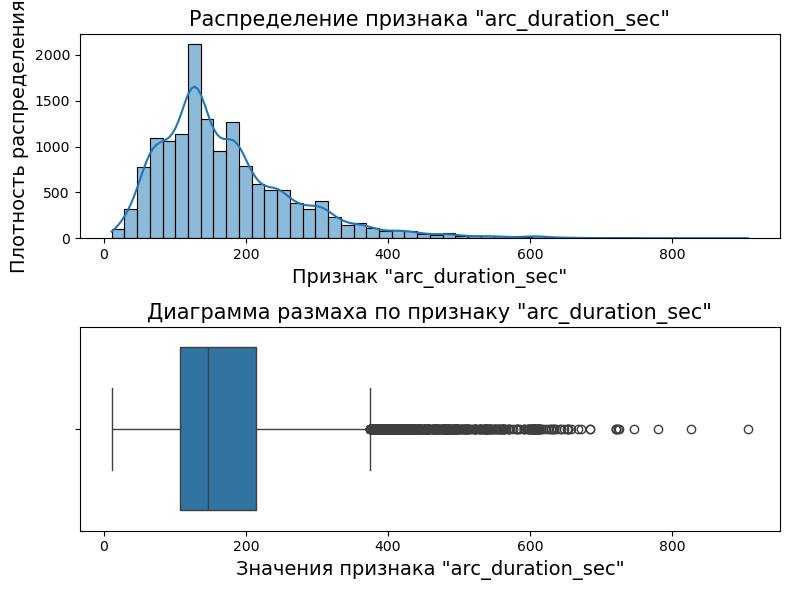

Описательная статистика для признака "active_power":


count    14872.000000
mean         0.662753
std          0.258916
min          0.223120
25%          0.467114
50%          0.599587
75%          0.830314
max          1.463773
Name: active_power, dtype: float64


Количество выбросов по IQR: 70 (0.47%)


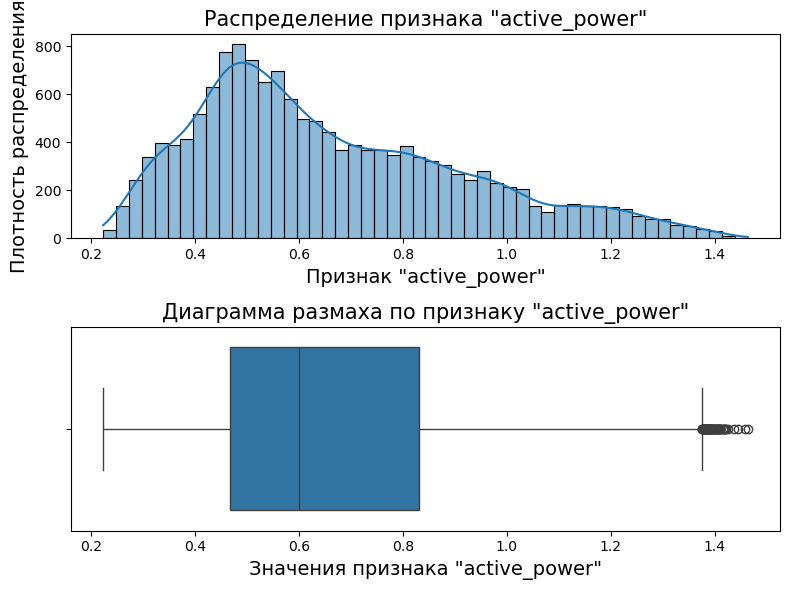

Описательная статистика для признака "reactive_power":


count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64


Количество выбросов по IQR: 198 (1.33%)


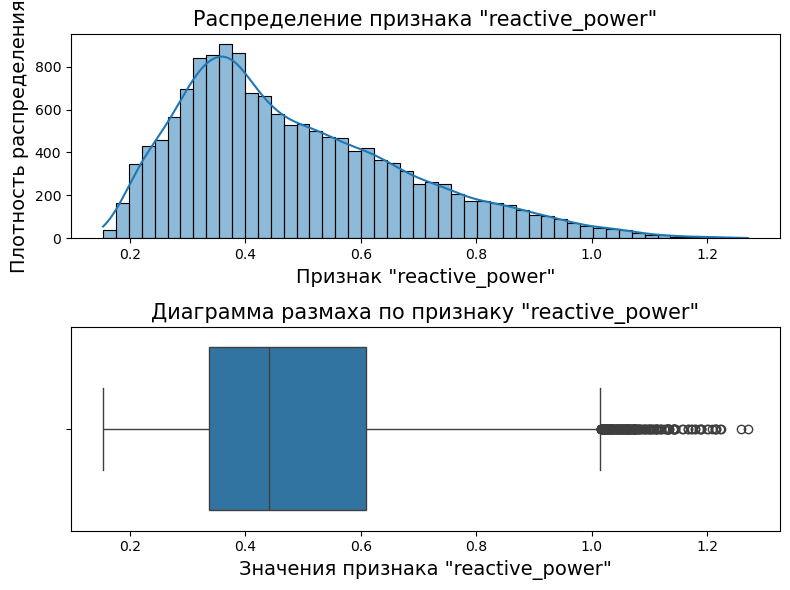

Описательная статистика для признака "active_energy":


count    14872.000000
mean       114.055512
std         83.013658
min          5.246505
25%         57.376903
50%         92.202561
75%        145.987744
max        898.200876
Name: active_energy, dtype: float64


Количество выбросов по IQR: 699 (4.70%)


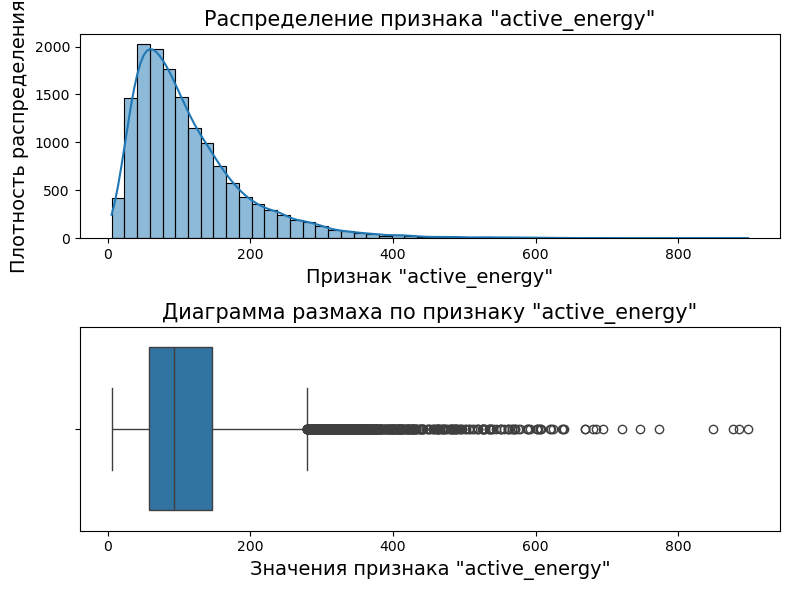

Описательная статистика для признака "reactive_energy":


count    14872.000000
mean        83.760479
std         61.666643
min          3.566134
25%         41.885407
50%         67.548320
75%        106.993962
max        635.262558
Name: reactive_energy, dtype: float64


Количество выбросов по IQR: 724 (4.87%)


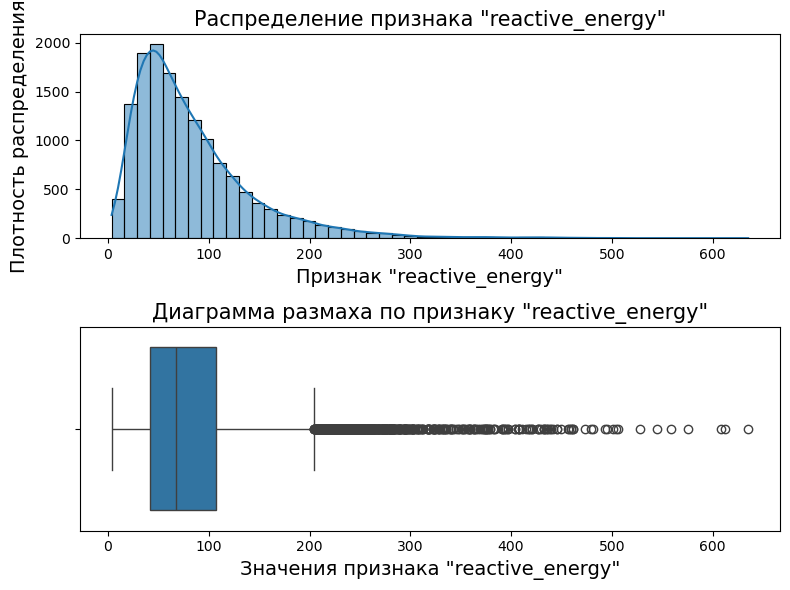

Описательная статистика для признака "full_power":


count    14872.000000
mean         0.823385
std          0.323494
min          0.275718
25%          0.578813
50%          0.746591
75%          1.030390
max          1.898158
Name: full_power, dtype: float64


Количество выбросов по IQR: 84 (0.56%)


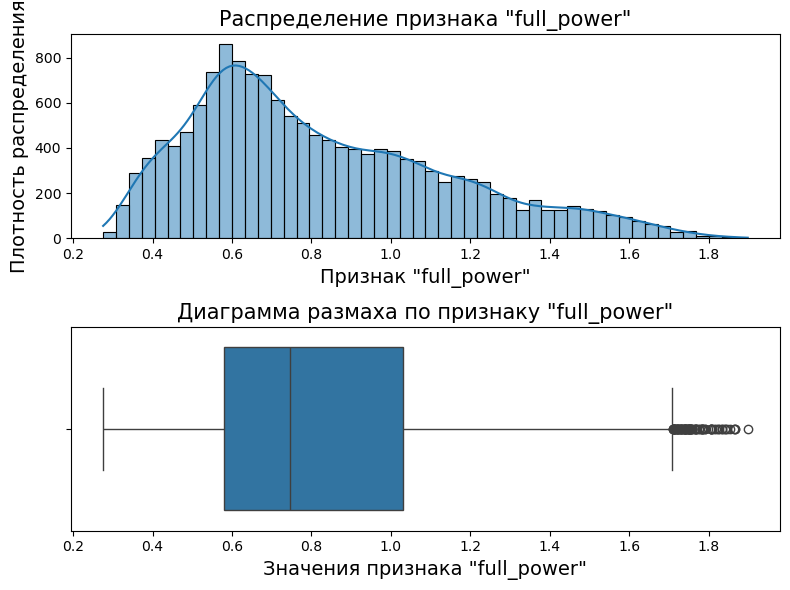

Описательная статистика для признака "full_energy":


count    14872.000000
mean       141.657368
std        103.207107
min          6.409531
25%         71.158372
50%        114.486341
75%        181.366353
max       1084.729420
Name: full_energy, dtype: float64


Количество выбросов по IQR: 700 (4.71%)


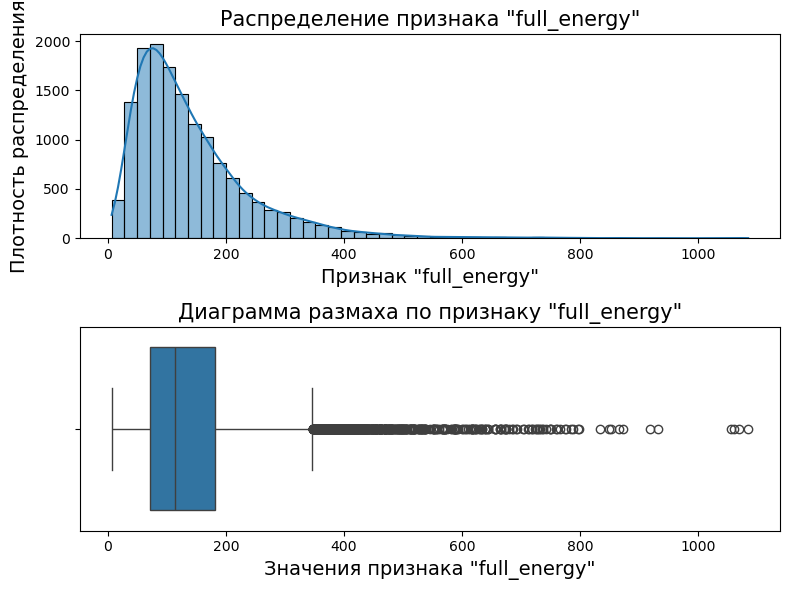

In [33]:
features = ['arc_duration_sec', 'active_power', 'reactive_power', 'active_energy', 'reactive_energy', 'full_power', 'full_energy']

for feature in features:
    print('='*100)
    viz_df(data_arc, feature)

Сгрупируем данные по ключу, возьём среднее значение. Столбцы со временем начала и конца нагрева оставлять не будем, оставим продолжительность нагрева в секунадах.

In [35]:
data_arc = pd.pivot_table(data_arc, values=['arc_duration_sec', 'active_power', 'reactive_power', 'active_energy', 'reactive_energy', 'full_power', 'full_energy'],
                              index='key', aggfunc='sum').reset_index()
# провепяем
display(data_arc.head())
display(data_arc.shape)

,key,active_energy,active_power,arc_duration_sec,full_energy,full_power,reactive_energy,reactive_power
0,1,628.616930,3.036730,1098.0,770.282114,3.718736,444.489437,2.142821
1,2,395.281800,2.139408,811.0,481.760005,2.588349,274.689995,1.453357
2,3,581.774624,4.063641,655.0,722.837668,5.019223,428.038924,2.937457
3,4,543.710274,2.706489,741.0,683.455597,3.400038,413.941977,2.056992
4,5,412.180480,2.252950,869.0,512.169934,2.816980,303.070918,1.687991


(3213, 8)

**Вывод:** все признаки имеют разумные масштабы и адекватные распределения. Выбросы составляют небольшую долю (до ~5%), принято решение их оставить. Данные сгруппированы по ключу.

### data_bulk

In [41]:
# изменим названия столбцов
data_bulk.columns = data_bulk.columns.str.replace(' ', '_').str.lower()

# проверяем
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

В датафрейме наблюдается много пропущенных значений, которые означают отсутсвие ввода материала в сплав. Заменим пропущенные значения на нули.

In [43]:
# заменяем все пропущенные значения на 0
data_bulk = data_bulk.fillna(0)

# проверяем
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


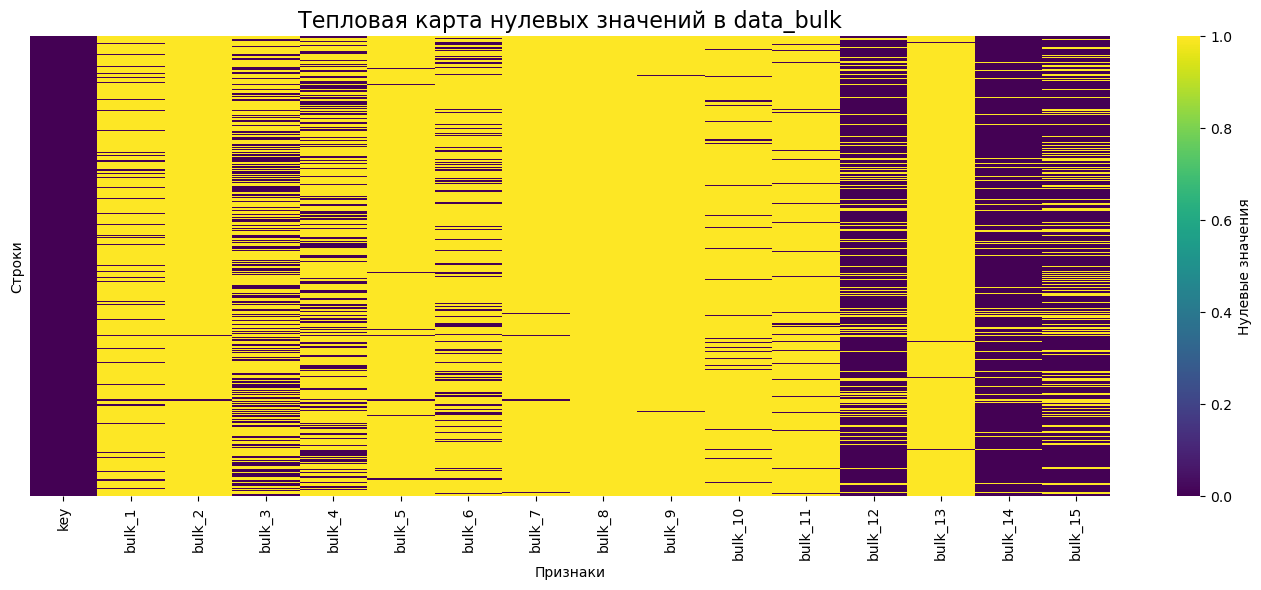

In [45]:
# визуализируем нулевые значения
plt.figure(figsize=(14, 6))
sns.heatmap(data_bulk == 0, cmap='viridis', yticklabels=False, cbar=True, cbar_kws={'label': 'Нулевые значения'})
plt.title('Тепловая карта нулевых значений в data_bulk', fontsize=16)
plt.xlabel('Признаки')
plt.ylabel('Строки')
plt.tight_layout()
plt.show()

**Вывод:** заменили пропущенные значения на 0, так пропуски означали отсутствие добавления материала в сплав.

### data_bulk_time

In [49]:
# изменим названия столбцов
data_bulk_time.columns = data_bulk_time.columns.str.replace(' ', '_').str.lower()

# проверяем
data_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [50]:
# заменяем все пропущенные значения на 0
data_bulk_time = data_bulk_time.fillna(0)

# проверяем
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


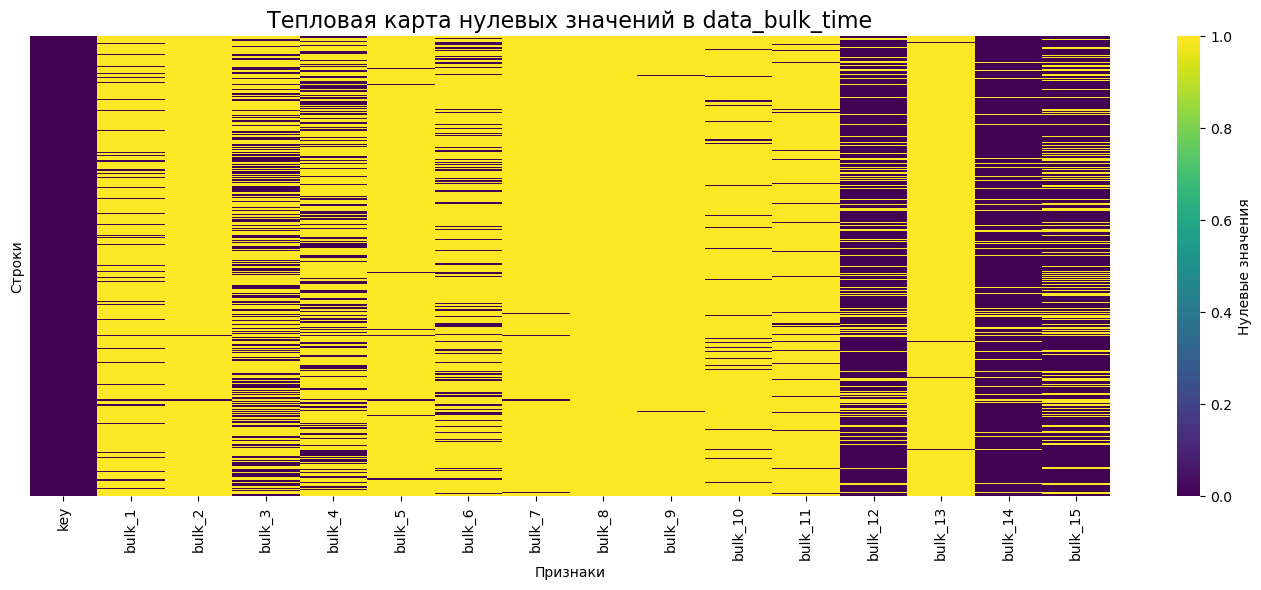

In [51]:
plt.figure(figsize=(14, 6))
sns.heatmap(data_bulk_time == 0, cmap='viridis', yticklabels=False, cbar=True, cbar_kws={'label': 'Нулевые значения'})
plt.title('Тепловая карта нулевых значений в data_bulk_time', fontsize=16)
plt.xlabel('Признаки')
plt.ylabel('Строки')
plt.tight_layout()
plt.show()

Выделим новые признаки -  длительность подачи материалов в секундах и число типов материалов, которые подавались.

In [53]:
# конвертируем нули в NaT, остальные строки в datetime
for col in data_bulk_time.columns:
    if col.startswith('bulk_'):
        data_bulk_time[col] = pd.to_datetime(
            data_bulk_time[col].replace(0, pd.NaT),
            errors='coerce'
        )

# список колонок с временными метками
time_cols = [c for c in data_bulk_time.columns if c.startswith('bulk_')]

# время первой подачи (минимальное ненулевое время)
data_bulk_time['bulk_first_time'] = data_bulk_time[time_cols].min(axis=1)

# время последней подачи (максимальное ненулевое время)
data_bulk_time['bulk_last_time']  = data_bulk_time[time_cols].max(axis=1)

# длительность подачи материалов в секундах
data_bulk_time['bulk_duration_sec'] = (
    (data_bulk_time['bulk_last_time'] - data_bulk_time['bulk_first_time'])
    .dt.total_seconds()
    .fillna(0)  # если ни одного времени — длительность 0
)

# число типов материалов, которые подавались
data_bulk_time['bulk_types_count'] = data_bulk_time[time_cols].notna().sum(axis=1)

# удаляем ненужные столбцы
columns_to_drop = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 
'bulk_first_time', 'bulk_last_time']
data_bulk_time = data_bulk_time.drop(columns_to_drop, axis=1)

# проверяем
data_bulk_time.head()

,key,bulk_duration_sec,bulk_types_count
0,1,1085.0,4
1,2,1000.0,4
2,3,983.0,4
3,4,878.0,4
4,5,205.0,4



Описательная статистика для признака "bulk_duration_sec":


count     3129.000000
mean       964.906679
std        798.088025
min          0.000000
25%        485.000000
50%        877.000000
75%       1311.000000
max      13683.000000
Name: bulk_duration_sec, dtype: float64


Количество выбросов по IQR: 89 (2.84%)


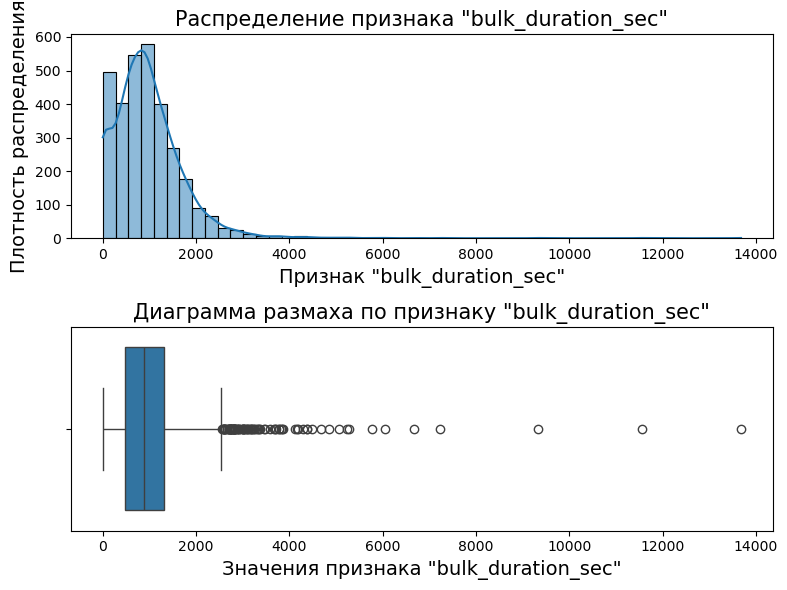


Описательная статистика для признака "bulk_types_count":


count    3129.000000
mean        3.566315
std         1.216165
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: bulk_types_count, dtype: float64


Количество выбросов по IQR: 368 (11.76%)


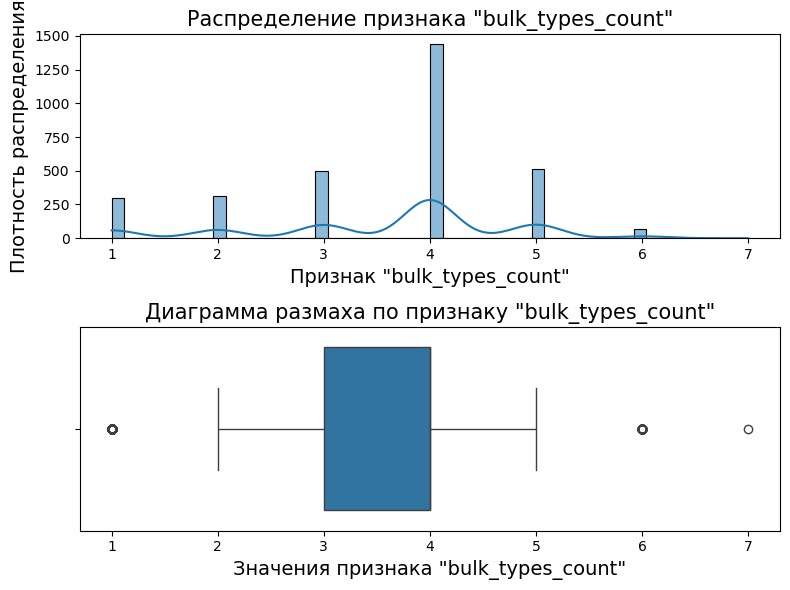

In [55]:
# визулизируем распределение новых признаков
for feature in ['bulk_duration_sec', 'bulk_types_count']:
    print('\n' + '='*100)
    viz_df(data_bulk_time, feature)

**Вывод:** пропуским в этом датафрейме соответсвуют пропускам в датафрейме data_bulk, они заменены на 0. Значения в данном датафрейме означают время подачи материала. Были выделены новые признаки - длительность подачи материалов в секундах и число типов материалов, которые подавались, остальные столбцы удалены.

### data_gas

In [59]:
# переименовываем столбцы
data_gas.columns = ['key', 'gas_1']

# проверяем
data_gas.columns

Index(['key', 'gas_1'], dtype='object')

Описательная статистика для признака "gas_1":


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64


Количество выбросов по IQR: 126 (3.89%)


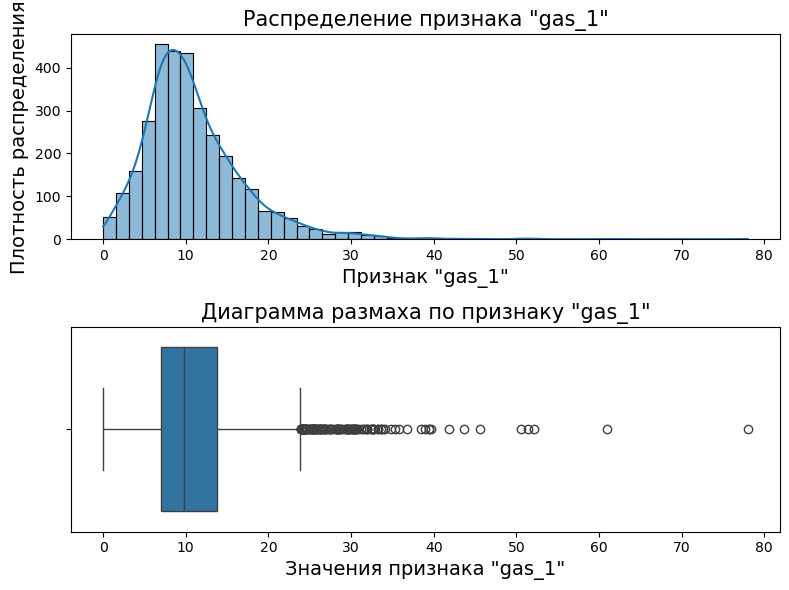

In [60]:
viz_df(data_gas, 'gas_1')

**Вывод:** количество выбросов составляет менее 5%. Оставим их.

### data_temp

In [64]:
# переименовываем столбцы
data_temp.columns = ['key', 'time', 'temp']

# проверяем
data_temp.head()

,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [65]:
# меняем формат столбца на datetime
data_temp['time'] = pd.to_datetime(data_temp['time'])

# проверяем
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     18092 non-null  int64         
 1   time    18092 non-null  datetime64[ns]
 2   temp    14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Описательная статистика для признака "temp":


count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


Количество выбросов по IQR: 835 (4.62%)


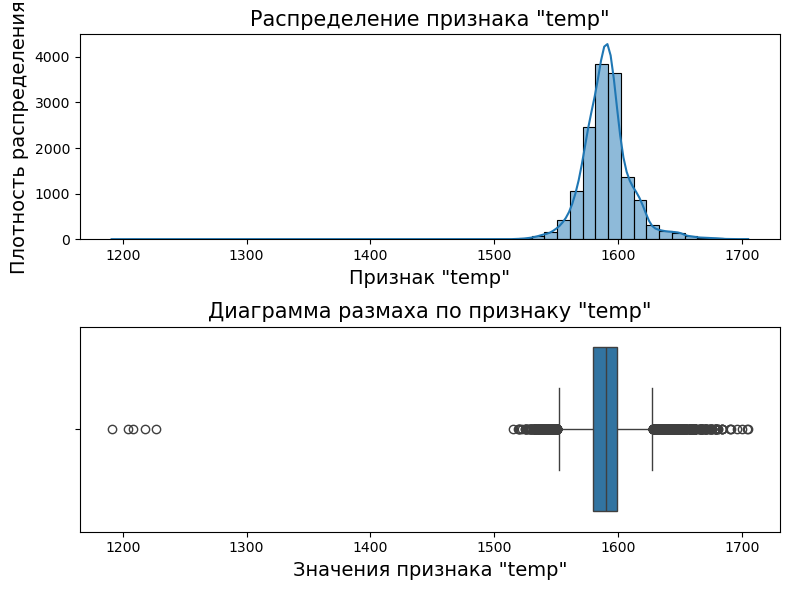

In [66]:
# визуализируем
viz_df(data_temp, 'temp')

Удалим строки, в которых температура меньше 1400 С (считаем это за сильные выбросы).

In [68]:
data_temp = data_temp.query('temp >= 1400')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     14660 non-null  int64         
 1   time    14660 non-null  datetime64[ns]
 2   temp    14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB


Сгруппируем данные по номеру партии и выделим новые признаки: начальную температуру, конечную температуру (целевой признак), количиство замеров, время начала замера, время окончания замера, продолжительность замера. Удаляем столбцы со временем, так как они больше неиформативны.

In [71]:
# сортируем данные по key и времени замера, чтобы first/last соответствовали min/max по времени
data_temp = data_temp.sort_values(by=['key', 'time'])

# группируем данные по ковшу
grouped_data_temp = data_temp.groupby('key').agg(
    temp_first=('temp', 'first'),
    temp_last=('temp', 'last'),
    time_start=('time', 'min'),
    time_end=('time', 'max'),
    count_meas=('temp', 'count')
)

# фильтруем ковши с более чем одним измерением
data_temp = grouped_data_temp[grouped_data_temp['count_meas'] > 1]

# выводим ковши, которые были удалены
removed_keys = grouped_data_temp[grouped_data_temp['count_meas'] == 1].index.tolist()
print(f"Удалено ковшей с одним измерением: {len(removed_keys)}")
print(f"Номера удаленных ковшей: {removed_keys}")

Удалено ковшей с одним измерением: 740
Номера удаленных ковшей: [195, 279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2

In [72]:
# длительность замеров в минутах
data_temp['meas_duration_sec'] = (
    (data_temp['time_end'] - data_temp['time_start']).dt.total_seconds()
)

# удаляем столбцы со временем 
data_temp = data_temp.drop(['time_start', 'time_end'], axis=1)

# проверяем сгруппированный датасет
data_temp.head()

,temp_first,temp_last,count_meas,meas_duration_sec
key,,,,
1,1571.0,1613.0,6,1714.0
2,1581.0,1602.0,5,1265.0
3,1596.0,1599.0,6,1753.0
4,1601.0,1625.0,5,1220.0
5,1576.0,1602.0,5,1536.0


Описательная статистика для признака "temp_first":


count    2475.000000
mean     1589.029899
std        24.998058
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: temp_first, dtype: float64


Количество выбросов по IQR: 15 (0.61%)


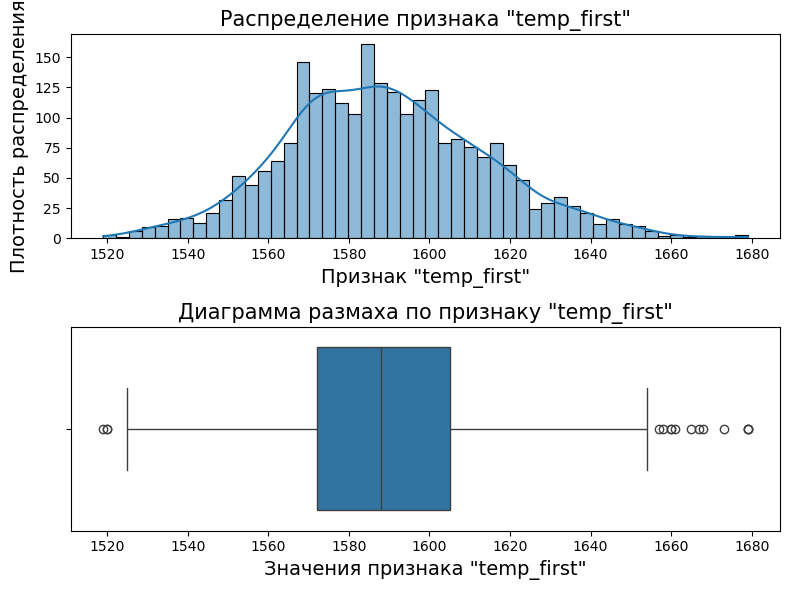

Описательная статистика для признака "temp_last":


count    2475.000000
mean     1595.336162
std        16.023153
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: temp_last, dtype: float64


Количество выбросов по IQR: 195 (7.88%)


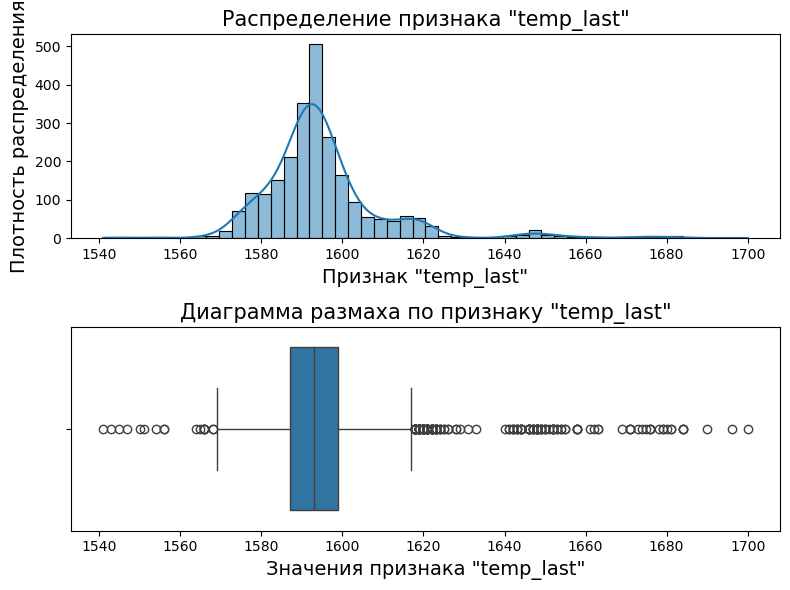

Описательная статистика для признака "count_meas":


count    2475.000000
mean        5.624242
std         1.610965
min         2.000000
25%         5.000000
50%         5.000000
75%         7.000000
max        17.000000
Name: count_meas, dtype: float64


Количество выбросов по IQR: 17 (0.69%)


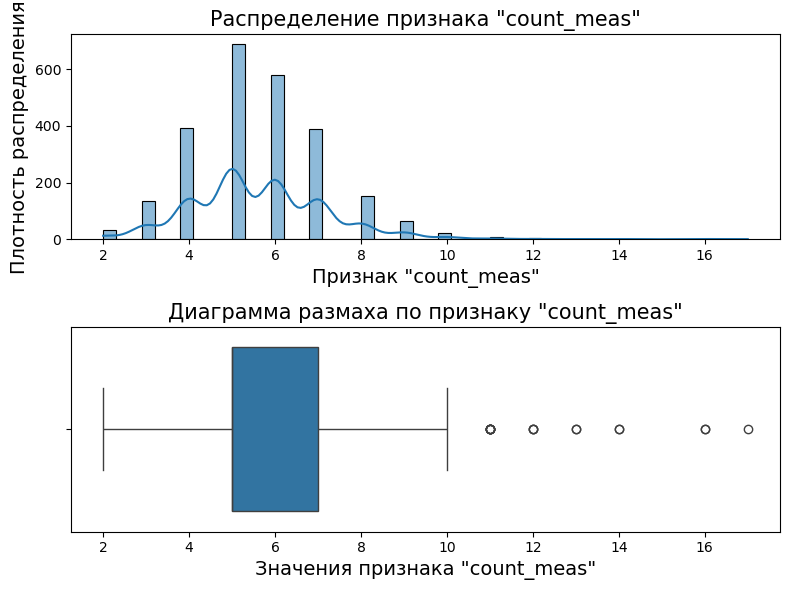

Описательная статистика для признака "meas_duration_sec":


count     2475.000000
mean      2279.871111
std       1373.958293
min        270.000000
25%       1544.500000
50%       2006.000000
75%       2738.500000
max      23674.000000
Name: meas_duration_sec, dtype: float64


Количество выбросов по IQR: 75 (3.03%)


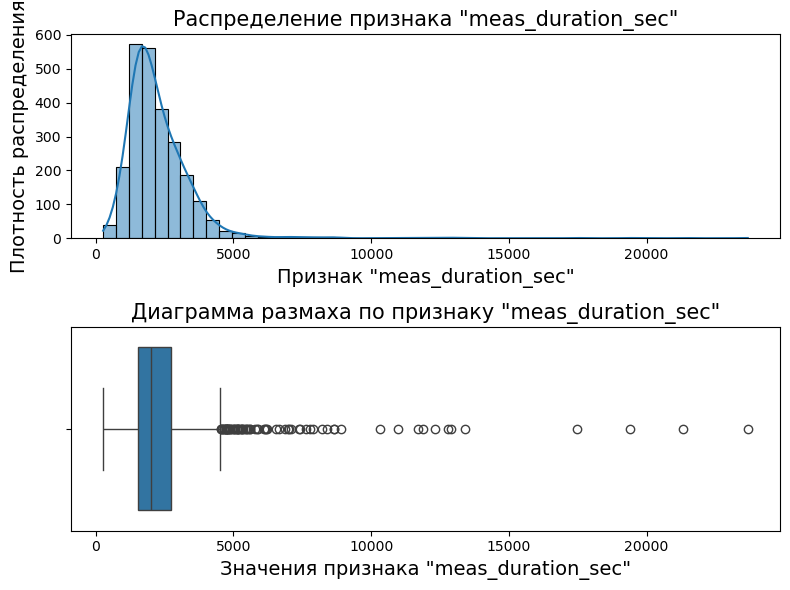

In [77]:
# смотрим распределение новых признаков
for feature in ['temp_first','temp_last','count_meas','meas_duration_sec']:
    print('='*100)
    viz_df(data_temp, feature)

**Вывод:** бфли удалены строки со значением температуры менее 1500 С. Сгруппировали данные по номеру партии и выделили новые признаки: минимальную температуру, максимальную температуру, среднюю температуру, количиство замеров, время начала замера, время окончания замера, продолжительность замера. Удалили столбцы со временем, так как они больше неиформативны. Выбросы составляют небольшую долю (до ~5%), принято решение их оставить.

### data_wire

In [81]:
# изменим названия столбцов
data_wire.columns = data_wire.columns.str.replace(' ', '_').str.lower()

# проверяем
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [82]:
# заменяем все пропущенные значения на 0
data_wire = data_wire.fillna(0)

# проверяем
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


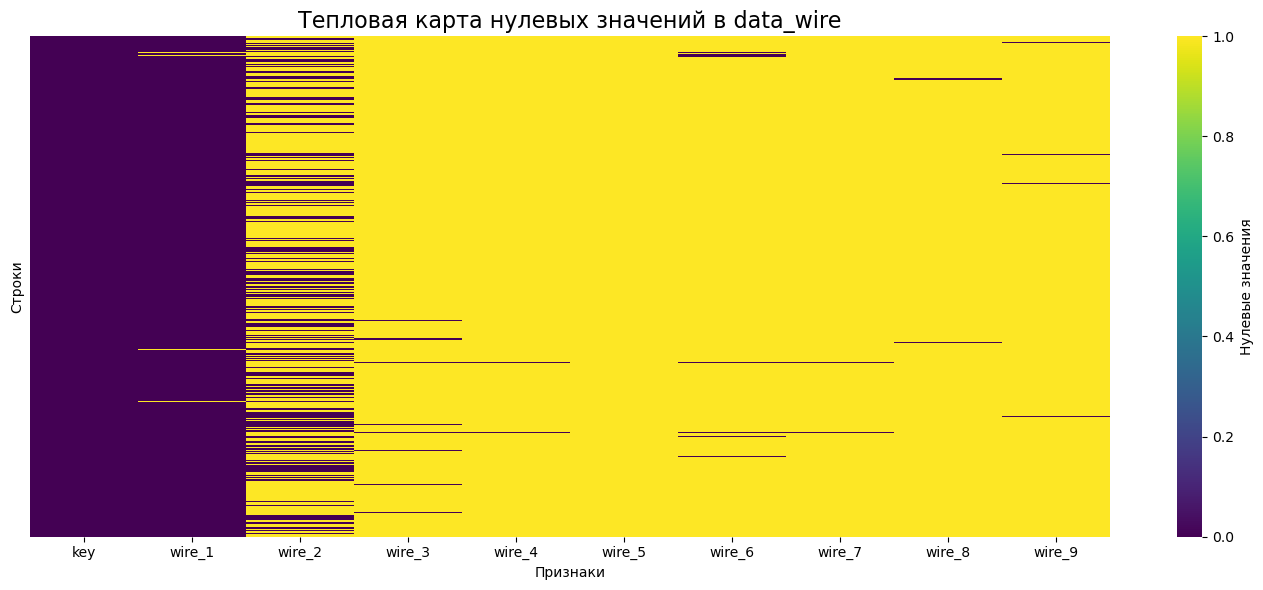

In [83]:
plt.figure(figsize=(14, 6))
sns.heatmap(data_wire == 0, cmap='viridis', yticklabels=False, cbar=True, cbar_kws={'label': 'Нулевые значения'})
plt.title('Тепловая карта нулевых значений в data_wire', fontsize=16)
plt.xlabel('Признаки')
plt.ylabel('Строки')
plt.tight_layout()
plt.show()

**Вывод:** заменили пропущенные значения на 0, так пропуски означали отсутствие добавления проволочных материалов в сплав.

### data_wire_time

In [87]:
# изменим названия столбцов
data_wire_time.columns = data_wire_time.columns.str.replace(' ', '_').str.lower()

# проверяем
data_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [88]:
# заменяем все пропущенные значения на 0
data_wire_time = data_wire_time.fillna(0)

# проверяем
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0


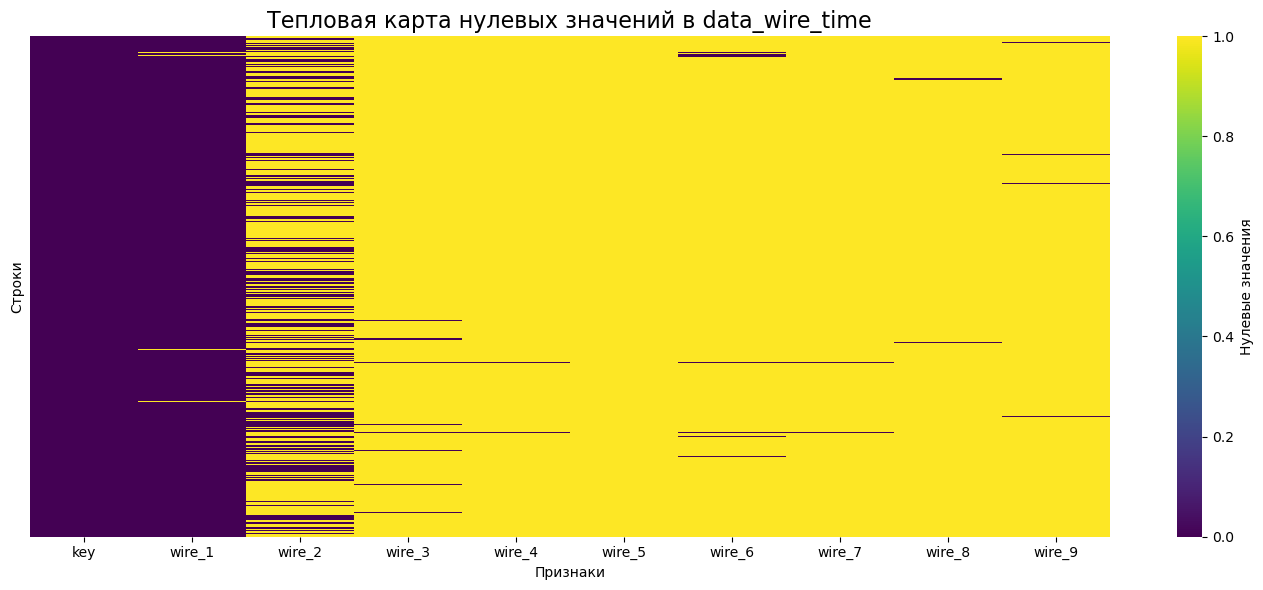

In [89]:
plt.figure(figsize=(14, 6))
sns.heatmap(data_wire_time == 0, cmap='viridis', yticklabels=False, cbar=True, cbar_kws={'label': 'Нулевые значения'})
plt.title('Тепловая карта нулевых значений в data_wire_time', fontsize=16)
plt.xlabel('Признаки')
plt.ylabel('Строки')
plt.tight_layout()
plt.show()

Выделим новые признаки - длительность подачи проволочных материалов в секундах и число типов проволочных материалов, которые подавались.

In [91]:
# конвертируем нули в NaT, остальные строки в datetime
for col in data_wire_time.columns:
    if col.startswith('wire_'):
        data_wire_time[col] = pd.to_datetime(
            data_wire_time[col].replace(0, pd.NaT),
            errors='coerce'
        )

# список колонок с временными метками
time_cols = [c for c in data_wire_time.columns if c.startswith('wire_')]

# время первой подачи (минимальное ненулевое время)
data_wire_time['wire_first_time'] = data_wire_time[time_cols].min(axis=1)

# время последней подачи (максимальное ненулевое время)
data_wire_time['wire_last_time']  = data_wire_time[time_cols].max(axis=1)

# длительность подачи проволочных материалов в секундах
data_wire_time['wire_duration_sec'] = (
    (data_wire_time['wire_last_time'] - data_wire_time['wire_first_time'])
    .dt.total_seconds()
    .fillna(0)  # если ни одного времени — длительность 0
)

# число типов проволочных материалов, которые подавались
data_wire_time['wire_types_count'] = data_wire_time[time_cols].notna().sum(axis=1)

# удаляем ненужные столбцы
columns_to_drop = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_first_time', 'wire_last_time']
data_wire_time = data_wire_time.drop(columns_to_drop, axis=1)

# проверяем
data_wire_time.head()

,key,wire_duration_sec,wire_types_count
0,1,0.0,1
1,2,0.0,1
2,3,0.0,1
3,4,0.0,1
4,5,310.0,2



Описательная статистика для признака "wire_duration_sec":


count    3081.000000
mean      214.519312
std       396.131967
min         0.000000
25%         0.000000
50%         0.000000
75%       401.000000
max      5937.000000
Name: wire_duration_sec, dtype: float64


Количество выбросов по IQR: 94 (3.05%)


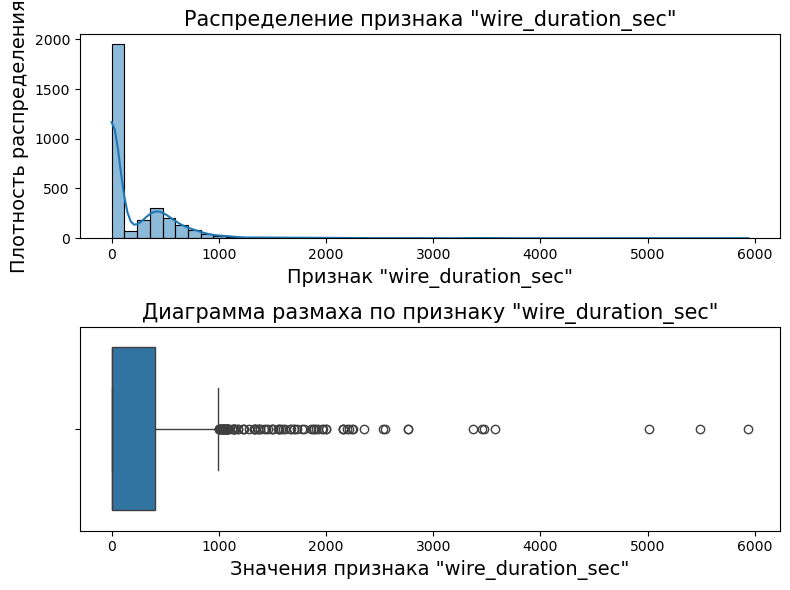


Описательная статистика для признака "wire_types_count":


count    3081.000000
mean        1.409932
std         0.578078
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: wire_types_count, dtype: float64


Количество выбросов по IQR: 12 (0.39%)


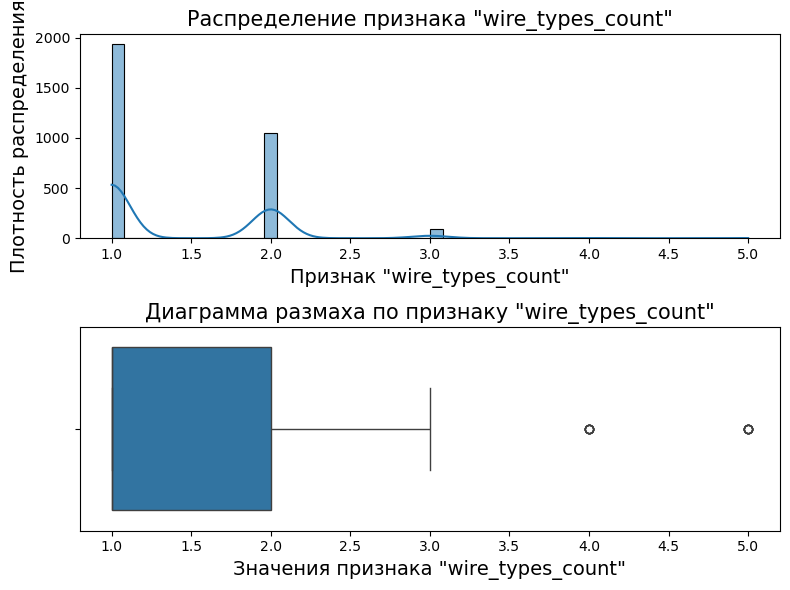

In [92]:
# визулизируем распределение новых признаков
for feature in ['wire_duration_sec', 'wire_types_count']:
    print('\n' + '='*100)
    viz_df(data_wire_time, feature)

**Вывод:** пропуски в этом датафрейме соответствуют пропускам в датафрейеме data_wire, они заменены на 0. Значения в данном датафрейме означают время подачи проволочного материала.  Выделены новые признаки - длительность подачи проволочных материалов в секундах и число типов проволочных материалов, которые подавались. Остальные столбцы удалены.

## 3. Объединение данных

In [95]:
# объединяем датафреймы
datas = [
    data_arc,
    data_bulk,
    data_bulk_time,
    data_gas,
    data_temp,
    data_wire,
    data_wire_time
]

df = reduce(lambda left, right: pd.merge(left, right, on='key', how='inner'), datas)

In [97]:
# смотрим готовый единый датафрейм
df_describe(df, 'Объединенный датафрейм')

Анализ: Объединенный датафрейм
Размерность: 2328 строк × 41 столбцов

Первые 10 строк:


,key,active_energy,active_power,arc_duration_sec,full_energy,full_power,reactive_energy,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_duration_sec,bulk_types_count,gas_1,temp_first,temp_last,count_meas,meas_duration_sec,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_duration_sec,wire_types_count
0,1,628.616930,3.036730,1098.0,770.282114,3.718736,444.489437,2.142821,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,1085.0,4,29.749986,1571.0,1613.0,6,1714.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2,395.281800,2.139408,811.0,481.760005,2.588349,274.689995,1.453357,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,1000.0,4,12.555561,1581.0,1602.0,5,1265.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3,581.774624,4.063641,655.0,722.837668,5.019223,428.038924,2.937457,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,983.0,4,28.554793,1596.0,1599.0,6,1753.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,543.710274,2.706489,741.0,683.455597,3.400038,413.941977,2.056992,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,878.0,4,18.841219,1601.0,1625.0,5,1220.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5,412.180480,2.252950,869.0,512.169934,2.816980,303.070918,1.687991,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,205.0,4,5.413692,1576.0,1602.0,5,1536.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.0,2
5,6,691.669688,2.725274,952.0,839.231310,3.313074,474.683338,1.881313,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,1250.0,4,11.273392,1543.0,1596.0,5,1497.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,515.0,2
6,7,491.550467,2.626877,673.0,613.576982,3.283913,366.161046,1.960419,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,1348.0,4,9.836267,1586.0,1599.0,5,1744.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,8,496.597268,2.678958,913.0,619.129542,3.405956,368.803429,2.096952,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,745.0,4,15.171553,1577.0,1598.0,5,1615.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,9,464.455338,3.520820,625.0,570.113675,4.335261,330.257804,2.527365,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,629.0,4,8.216623,1587.0,1592.0,6,1811.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,367.0,2
9,10,439.040344,3.118778,825.0,533.482050,3.791005,303.032346,2.154941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,495.0,3,6.529891,1574.0,1593.0,7,1551.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,264.0,2


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2328 non-null   int64  
 1   active_energy      2328 non-null   float64
 2   active_power       2328 non-null   float64
 3   arc_duration_sec   2328 non-null   float64
 4   full_energy        2328 non-null   float64
 5   full_power         2328 non-null   float64
 6   reactive_energy    2328 non-null   float64
 7   reactive_power     2328 non-null   float64
 8   bulk_1             2328 non-null   float64
 9   bulk_2             2328 non-null   float64
 10  bulk_3             2328 non-null   float64
 11  bulk_4             2328 non-null   float64
 12  bulk_5             2328 non-null   float64
 13  bulk_6             2328 non-null   float64
 14  bulk_7             2328 non-null   float64
 15  bulk_8             2328 non-null   float64
 16  bulk_9

,key,active_energy,active_power,arc_duration_sec,full_energy,full_power,reactive_energy,reactive_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_duration_sec,bulk_types_count,gas_1,temp_first,temp_last,count_meas,meas_duration_sec,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_duration_sec,wire_types_count
count,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.0,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000
mean,1251.461340,539.107742,3.125546,807.808419,669.912912,3.885267,396.477111,2.300860,3.429124,1.423110,47.368557,37.319588,2.641323,22.381014,2.005584,0.021048,0.445017,5.054983,4.246993,208.505155,1.067869,153.834622,120.004296,986.168814,3.593643,11.375511,1587.389605,1593.371993,5.694158,2322.071306,102.455296,17.617423,3.236305,0.306682,0.0,0.979240,0.006363,0.311445,0.317249,209.798540,1.397337
std,714.691385,257.280972,1.221019,340.823100,319.493496,1.518195,189.655454,0.904016,12.414595,19.086196,75.320213,58.650737,22.407040,55.752272,30.682797,1.015558,6.221971,20.922031,22.520153,157.036569,14.238096,81.416698,84.622085,815.745378,1.224234,6.393413,23.624276,11.198791,1.607920,1385.431810,43.545688,33.630013,27.948793,4.758764,0.0,8.695143,0.205749,4.403648,3.457298,390.155892,0.564478
min,1.000000,26.187544,0.267676,57.000000,33.430208,0.331897,20.779589,0.196228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.008399,1519.000000,1541.000000,2.000000,270.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,629.750000,368.187260,2.295340,581.000000,457.870652,2.843909,270.443382,1.670282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,501.000000,3.000000,7.282534,1571.000000,1587.000000,5.000000,1579.000000,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1254.500000,508.260683,3.035834,778.000000,630.813815,3.768661,371.695841,2.225900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,894.000000,4.000000,10.100687,1587.000000,1593.000000,6.000000,2045.500000,101.119202,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1867.250000,678.508092,3.834302,993.000000,841.459596,4.769753,495.136516,2.829179,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.250000,0.000000,204.000000,204.000000,1340.750000,4.000000,14.216939,1603.000000,1598.000000,7.000000,2791.500000,128.097058,23.110100,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,396.250000,2.000000
max,2499.000000,3718.054401,12.375636,4189.000000,4546.405812,15.288271,2612.081299,8.949049,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,13683.000000,7.000000,77.995040,1660.000000,1653.000000,17.000000,23674.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,5937.000000,5.000000



Пропущенные значения (по столбцам):


key                  0
active_energy        0
active_power         0
arc_duration_sec     0
full_energy          0
full_power           0
reactive_energy      0
reactive_power       0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_8               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
bulk_duration_sec    0
bulk_types_count     0
gas_1                0
temp_first           0
temp_last            0
count_meas           0
meas_duration_sec    0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_5               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
wire_duration_sec    0
wire_types_count     0
dtype: int64


Количество явных дубликатов:


0

**Вывод:** произведено объединение выбранных признаков в один датафрейм по ключу. Размер: 3021 строк × 41 столбец. Пропусков и дубликатов нет.

## 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Оценим корреляцию между признаками и целевым признаком (temp_last). 

/opt/anaconda3/lib/python3.12/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 4218336. Are interval variables set correctly?
  warnings.warn(


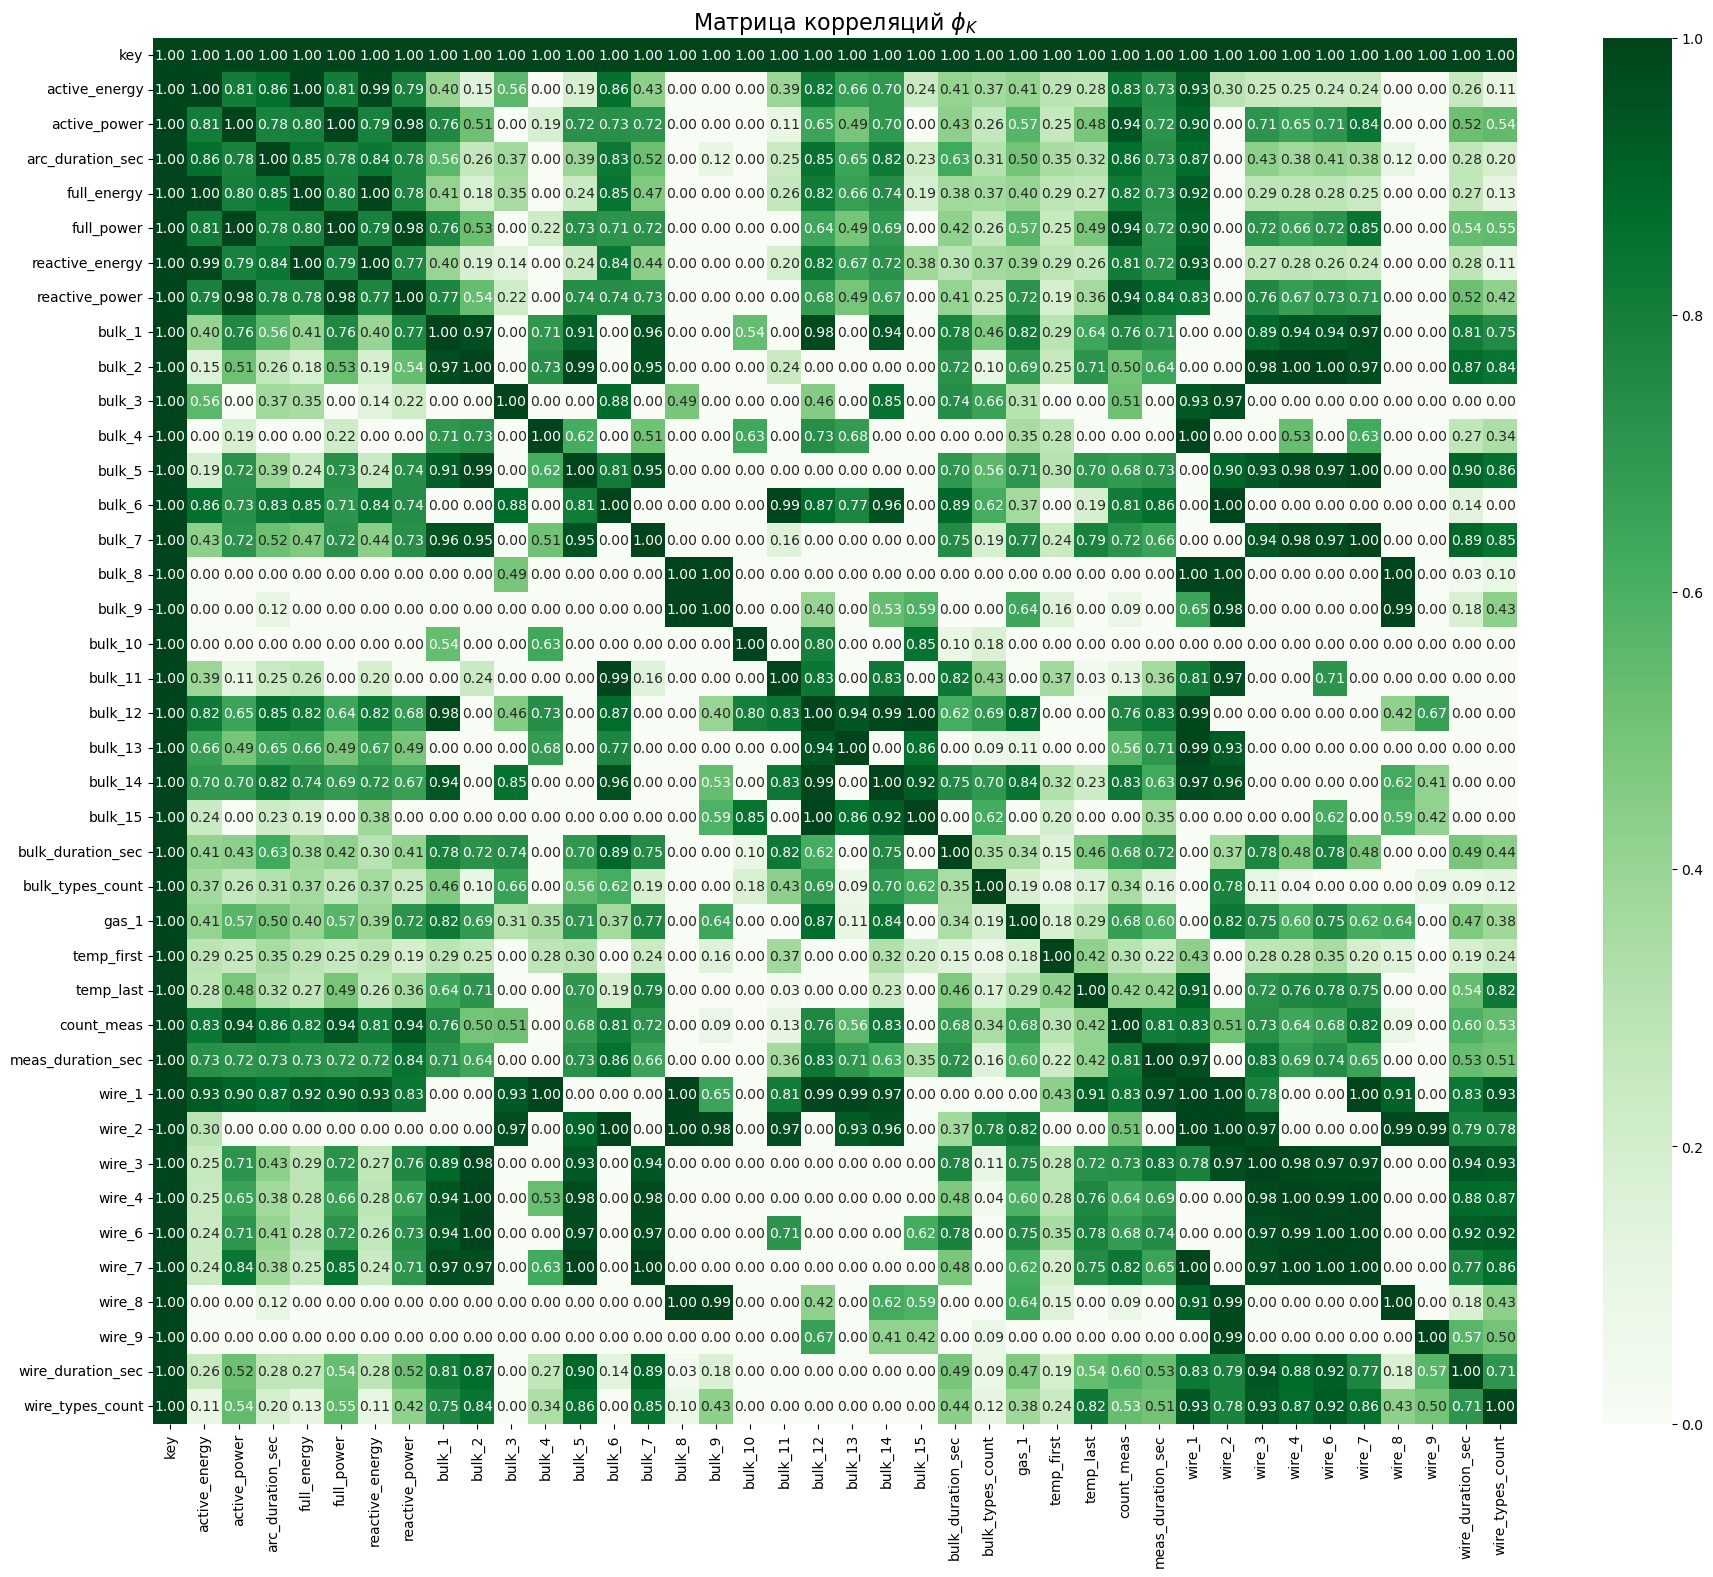

In [102]:
# смотрим матрицу корреляций
interval_cols = [
    'active_energy', 'active_power', 'arc_duration_sec',
    'full_energy', 'full_power', 'reactive_energy', 'reactive_power',
    'bulk_duration_sec', 'gas_1',
    'temp_first', 'temp_last', 'meas_duration_sec',
    'wire_duration_sec'
]

corr = df.phik_matrix(interval_cols=interval_cols, bins=10, verbose=False)

plt.figure(figsize=(22, 18))
sns.heatmap(corr, annot=True, cmap='Greens', fmt='.2f') 
plt.title(r'Матрица корреляций $\phi_K$', fontsize=16)
plt.show()

При оценке корреляции слишком сильная связь наблюдается между признаками 'reactive_energy', 'active_energy' (между собой и признаком 'full_energy'), между признаками 'reactive_power' и 'active_power' (между собой и признаком 'full_power'), между некотрыми признаками материалов и проволочных материалов. Принято решение их удалить и оставить аггрегированные признаки.  Столбец 'key' с нромером партии также удалим, нужды в нем больше нет.

In [105]:
# удаляем выбранные столбцы
columns_to_drop = ['key', 'reactive_energy', 'active_energy', 'reactive_power', 'active_power', 
                   *[f'bulk_{i}' for i in range(1, 16)],
                   *[f'wire_{i}' for i in range(1, 10)],]

df_final = df.drop(columns=columns_to_drop)

In [106]:
# смотрим финальный вариант датафрейма
df_describe(df_final, 'Финальный датафрейм')

Анализ: Финальный датафрейм
Размерность: 2328 строк × 12 столбцов

Первые 10 строк:


,arc_duration_sec,full_energy,full_power,bulk_duration_sec,bulk_types_count,gas_1,temp_first,temp_last,count_meas,meas_duration_sec,wire_duration_sec,wire_types_count
0,1098.0,770.282114,3.718736,1085.0,4,29.749986,1571.0,1613.0,6,1714.0,0.0,1
1,811.0,481.760005,2.588349,1000.0,4,12.555561,1581.0,1602.0,5,1265.0,0.0,1
2,655.0,722.837668,5.019223,983.0,4,28.554793,1596.0,1599.0,6,1753.0,0.0,1
3,741.0,683.455597,3.400038,878.0,4,18.841219,1601.0,1625.0,5,1220.0,0.0,1
4,869.0,512.169934,2.816980,205.0,4,5.413692,1576.0,1602.0,5,1536.0,310.0,2
5,952.0,839.231310,3.313074,1250.0,4,11.273392,1543.0,1596.0,5,1497.0,515.0,2
6,673.0,613.576982,3.283913,1348.0,4,9.836267,1586.0,1599.0,5,1744.0,0.0,1
7,913.0,619.129542,3.405956,745.0,4,15.171553,1577.0,1598.0,5,1615.0,0.0,1
8,625.0,570.113675,4.335261,629.0,4,8.216623,1587.0,1592.0,6,1811.0,367.0,2
9,825.0,533.482050,3.791005,495.0,3,6.529891,1574.0,1593.0,7,1551.0,264.0,2


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   arc_duration_sec   2328 non-null   float64
 1   full_energy        2328 non-null   float64
 2   full_power         2328 non-null   float64
 3   bulk_duration_sec  2328 non-null   float64
 4   bulk_types_count   2328 non-null   int64  
 5   gas_1              2328 non-null   float64
 6   temp_first         2328 non-null   float64
 7   temp_last          2328 non-null   float64
 8   count_meas         2328 non-null   int64  
 9   meas_duration_sec  2328 non-null   float64
 10  wire_duration_sec  2328 non-null   float64
 11  wire_types_count   2328 non-null   int64  
dtypes: float64(9), int64(3)
memory usage: 218.4 KB

Статистическое описание:


,arc_duration_sec,full_energy,full_power,bulk_duration_sec,bulk_types_count,gas_1,temp_first,temp_last,count_meas,meas_duration_sec,wire_duration_sec,wire_types_count
count,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000
mean,807.808419,669.912912,3.885267,986.168814,3.593643,11.375511,1587.389605,1593.371993,5.694158,2322.071306,209.798540,1.397337
std,340.823100,319.493496,1.518195,815.745378,1.224234,6.393413,23.624276,11.198791,1.607920,1385.431810,390.155892,0.564478
min,57.000000,33.430208,0.331897,0.000000,1.000000,0.008399,1519.000000,1541.000000,2.000000,270.000000,0.000000,1.000000
25%,581.000000,457.870652,2.843909,501.000000,3.000000,7.282534,1571.000000,1587.000000,5.000000,1579.000000,0.000000,1.000000
50%,778.000000,630.813815,3.768661,894.000000,4.000000,10.100687,1587.000000,1593.000000,6.000000,2045.500000,0.000000,1.000000
75%,993.000000,841.459596,4.769753,1340.750000,4.000000,14.216939,1603.000000,1598.000000,7.000000,2791.500000,396.250000,2.000000
max,4189.000000,4546.405812,15.288271,13683.000000,7.000000,77.995040,1660.000000,1653.000000,17.000000,23674.000000,5937.000000,5.000000



Пропущенные значения (по столбцам):


arc_duration_sec     0
full_energy          0
full_power           0
bulk_duration_sec    0
bulk_types_count     0
gas_1                0
temp_first           0
temp_last            0
count_meas           0
meas_duration_sec    0
wire_duration_sec    0
wire_types_count     0
dtype: int64


Количество явных дубликатов:


0

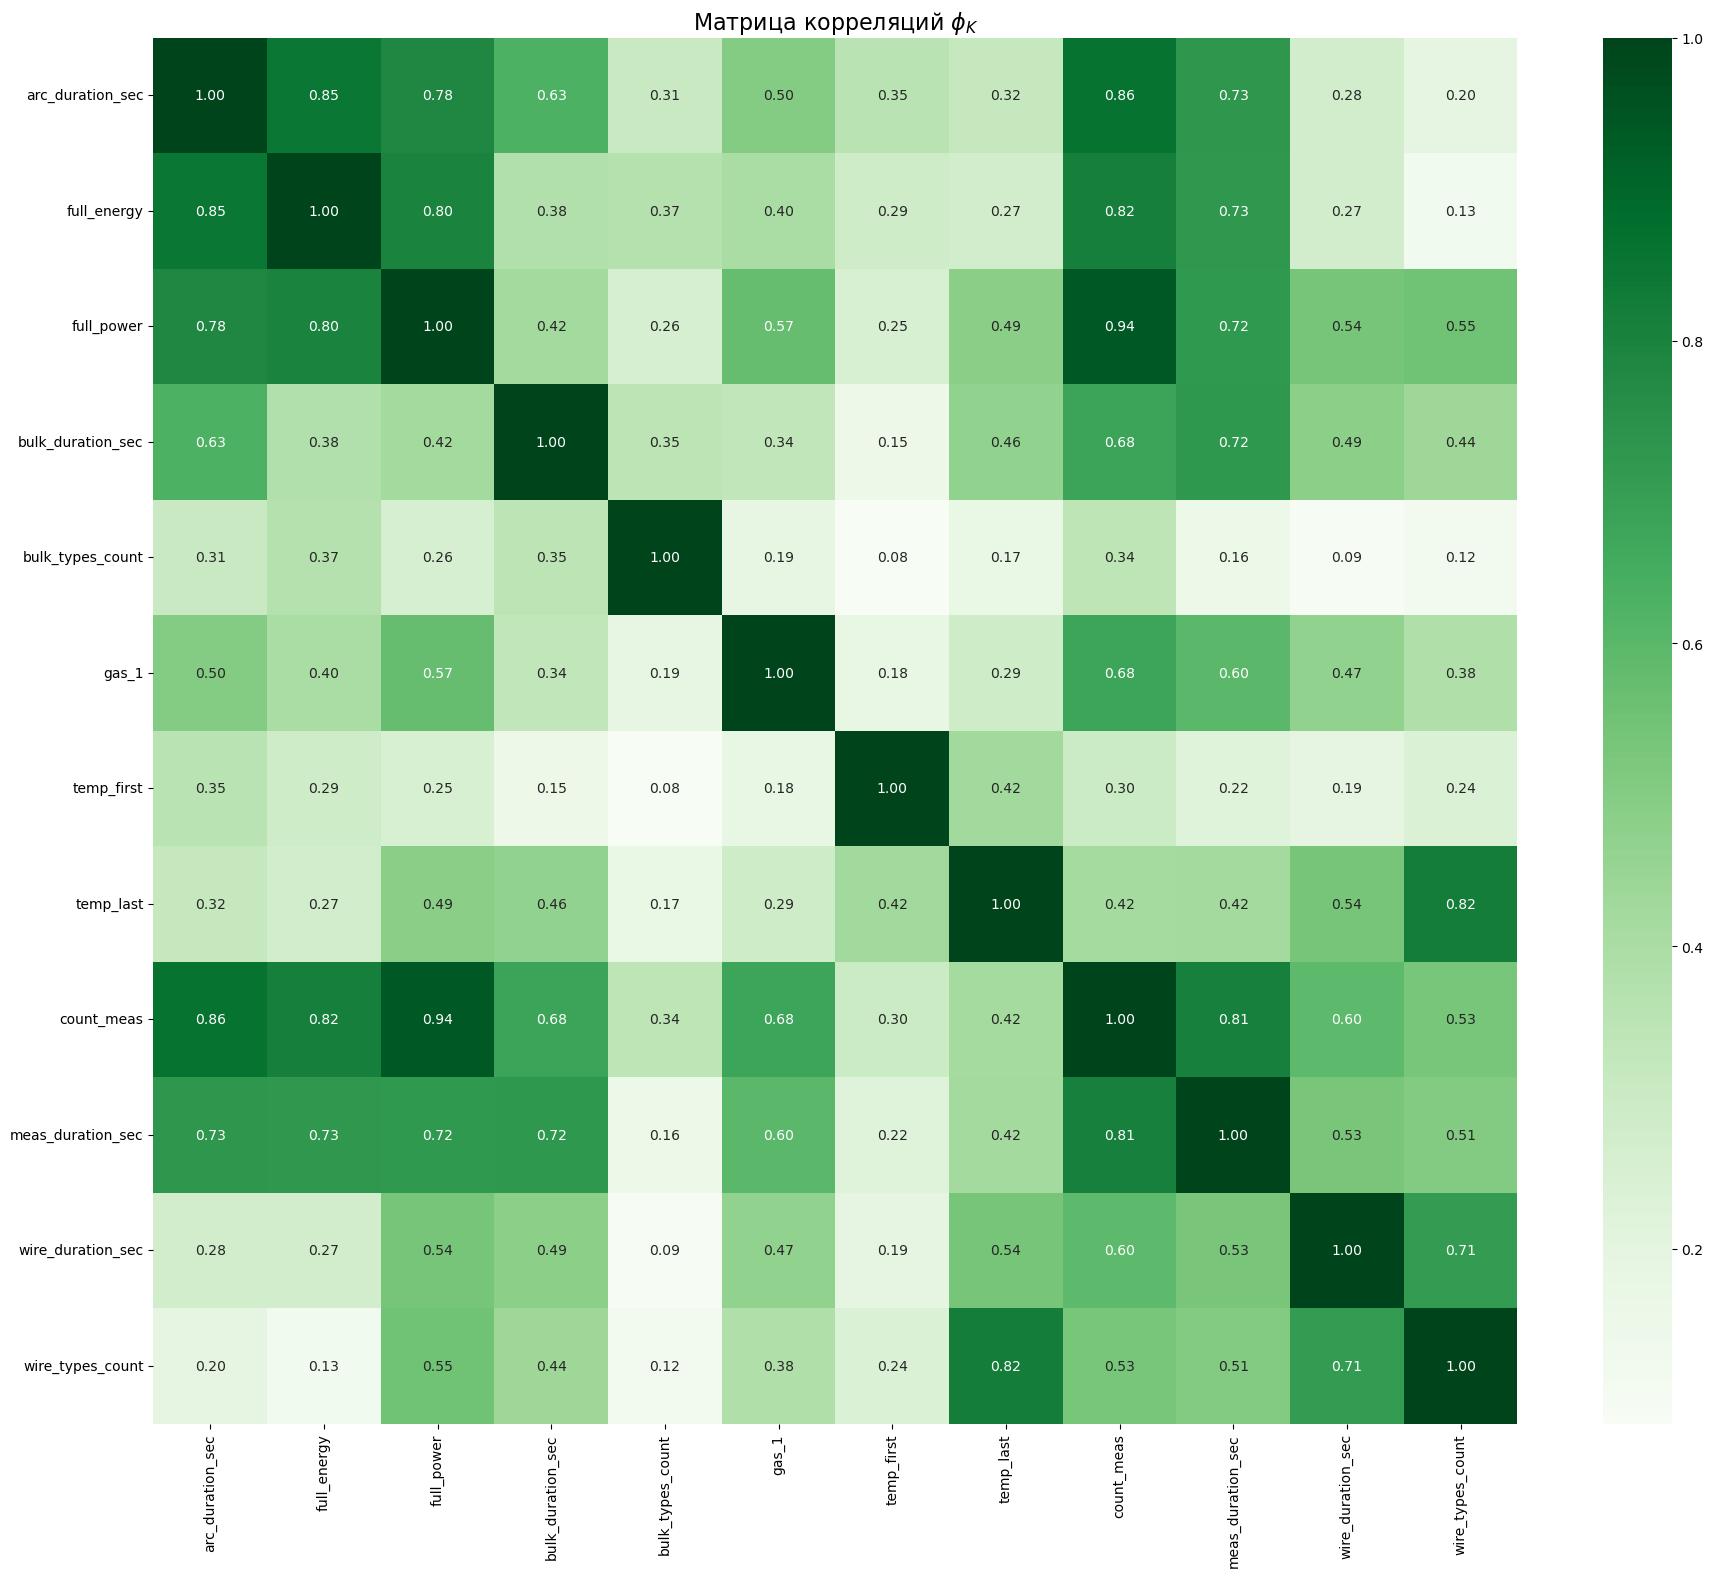

In [107]:
# повторно смотрим матрицу корреляций
interval_cols = [
    'full_energy', 'full_power', 'arc_duration_sec',
    'bulk_duration_sec', 'gas_1',
    'temp_first', 'temp_last', 'meas_duration_sec',
    'wire_duration_sec'
]

corr = df_final.phik_matrix(interval_cols=interval_cols, bins=10, verbose=False)

plt.figure(figsize=(22, 18))
sns.heatmap(corr, annot=True, cmap='Greens', fmt='.2f') 
plt.title(r'Матрица корреляций $\phi_K$', fontsize=16)
plt.show()

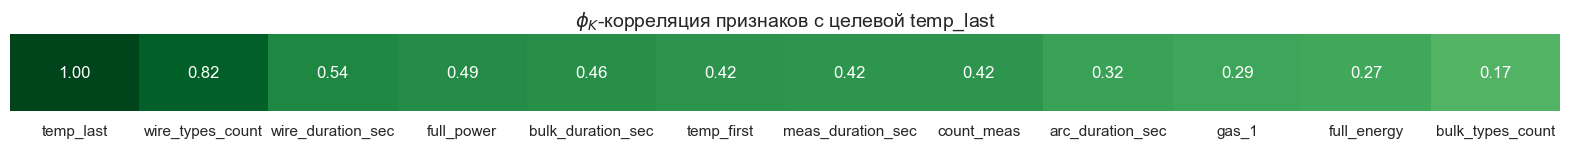

In [108]:
# строим тепловую карту одной строки для целевого признака
corr_temp = corr['temp_last'].sort_values(ascending=False).to_frame().T

sns.set(rc={'figure.figsize': (20, 1)})
sns.heatmap(
    corr_temp,
    annot=True,
    cmap='Greens',
    center=0,
    fmt='.2f',
    cbar=False,      
    xticklabels=corr_temp.columns
)
plt.title(r'$\phi_K$-корреляция признаков с целевой temp_last', fontsize=14)
plt.yticks([])     
plt.show()

In [109]:
df_final.columns

Index(['arc_duration_sec', 'full_energy', 'full_power', 'bulk_duration_sec',
       'bulk_types_count', 'gas_1', 'temp_first', 'temp_last', 'count_meas',
       'meas_duration_sec', 'wire_duration_sec', 'wire_types_count'],
      dtype='object')

**Вывод:** было установлено, что некоторые признаки имеют сильную корреляцию между собой. Принято решение их удлаить. В итоговый датафрейм вошли признаки - 'arc_duration_sec', 'full_energy', 'full_power', 'bulk_duration_sec', 'bulk_types_count', 'gas_1', 'temp_first', 'temp_last', 'count_meas', 'meas_duration_sec', 'wire_duration_sec', 'wire_types_count'. Целевой признак - 'last_temp'. Наиболее сильная корреляция наблюдается между ним и признаками 'wire_types_count', 'wire_duration_sec', 'full_power'.

In [114]:
df_final.head()

,arc_duration_sec,full_energy,full_power,bulk_duration_sec,bulk_types_count,gas_1,temp_first,temp_last,count_meas,meas_duration_sec,wire_duration_sec,wire_types_count
0,1098.0,770.282114,3.718736,1085.0,4,29.749986,1571.0,1613.0,6,1714.0,0.0,1
1,811.0,481.760005,2.588349,1000.0,4,12.555561,1581.0,1602.0,5,1265.0,0.0,1
2,655.0,722.837668,5.019223,983.0,4,28.554793,1596.0,1599.0,6,1753.0,0.0,1
3,741.0,683.455597,3.400038,878.0,4,18.841219,1601.0,1625.0,5,1220.0,0.0,1
4,869.0,512.169934,2.816980,205.0,4,5.413692,1576.0,1602.0,5,1536.0,310.0,2


## 5. Подготовка данных

In [116]:
# задаём RANDOM_STATE и размер тестовой выборки
RANDOM_STATE = 50525
TEST_SIZE = 0.25

# выделяем целевой признак
X = df_final.drop(columns=['temp_last'])
y = df_final['temp_last']

# делим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# определием, какие колонки масштабировать
int_cols = ['bulk_types_count', 'count_meas', 'wire_types_count']
num_cols = [col for col in X.columns if col not in int_cols]

# создаём и обучаем StandardScaler 
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])

# применяем преобразование к тестовым данным
X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# проверяем размеры
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled: ", X_test_scaled.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)


X_train_scaled: (1746, 11)
X_test_scaled:  (582, 11)
y_train: (1746,)
y_test:  (582,)


**Вывод:** данные разделены на обучающую и тестовую выборки и подготовлены к обучению моделей машинного обучения.

##  6. Обучение моделей машинного обучения

In [122]:
models = {}
cv_scores = {}

#### 6.1 Линейная регрессия

In [124]:
lr = LinearRegression()
lr_cv_score = -cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
models['LinearRegression'] = lr
cv_scores['LinearRegression'] = lr_cv_score

print(f"MAE модели линейной регрессии: {lr_cv_score:.4f}")

MAE модели линейной регрессии: 6.3031


#### 6.2 Случайный лес

In [127]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
}
search_rf = RandomizedSearchCV(rf, param_rf, scoring='neg_mean_absolute_error', cv=5, n_iter=5, random_state=50525)
search_rf.fit(X_train_scaled, y_train)
best_rf = search_rf.best_estimator_
mae_rf = -search_rf.best_score_
models['Random Forest'] = best_rf
cv_scores['Random Forest'] = mae_rf

print(f"MAE модели случайного леса: {mae_rf:.4f}")
print("Лучшие гиперпараметры для случайного леса:")
for param, value in search_rf.best_params_.items():
    print(f"  {param}: {value}")

MAE модели случайного леса: 6.3443
Лучшие гиперпараметры для случайного леса:
  n_estimators: 50
  min_samples_split: 2
  max_depth: 10


#### 6.3 CatBoost

In [129]:
cat = CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)
param_cat = {
    'depth': [4, 6, 8, 10],                     
    'learning_rate': [0.01, 0.03, 0.05, 0.1],   
    'iterations': [200, 500, 1000],             
    'l2_leaf_reg': [1, 3, 5, 7, 9],             
    'bagging_temperature': [0, 0.5, 1],        
    'random_strength': [0.5, 1, 2]            
}
search_cat = RandomizedSearchCV(cat, param_cat, scoring='neg_mean_absolute_error', cv=5, n_iter=5, random_state=50525)
search_cat.fit(X_train_scaled, y_train)
best_cat = search_cat.best_estimator_
mae_cat = -search_cat.best_score_
models['CatBoost'] = best_cat
cv_scores['CatBoost'] = mae_cat

print(f"MAE модели CatBoost: {mae_cat:.4f}")
print("Лучшие гиперпараметры CatBoost:")
for param, value in search_cat.best_params_.items():
    print(f"  {param}: {value}")

MAE модели CatBoost: 6.2269
Лучшие гиперпараметры CatBoost:
  random_strength: 1
  learning_rate: 0.1
  l2_leaf_reg: 7
  iterations: 200
  depth: 6
  bagging_temperature: 0.5


#### 6.4 LGBMRegressor

In [131]:
lgbm = LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)
param_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
}
search_lgbm = RandomizedSearchCV(lgbm, param_lgbm, scoring='neg_mean_absolute_error', cv=5, n_iter=5, random_state=50525)
search_lgbm.fit(X_train_scaled, y_train)
best_lgbm = search_lgbm.best_estimator_
mae_lgbm = -search_lgbm.best_score_
models['LightGBM'] = best_lgbm
cv_scores['LightGBM'] = mae_lgbm

print(f"LightGBM - MAE: {mae_lgbm:.4f}")
print("Лучшие гиперпараметры LightGBM:")
for param, value in search_lgbm.best_params_.items():
    print(f"  {param}: {value}")

LightGBM - MAE: 6.3408
Лучшие гиперпараметры LightGBM:
  n_estimators: 100
  max_depth: 5
  learning_rate: 0.05


In [132]:
# сравнительная таблица
results_df = pd.DataFrame({
    'Модель': list(cv_scores.keys()),
    'MAE на кросс-валидации': list(cv_scores.values())
})

# добавим колонку с достижением целевой метрики
results_df['MAE ≤ 6.8'] = results_df['MAE на кросс-валидации'] <= 6.8

# сортировка по MAE
results_df = results_df.sort_values(by='MAE на кросс-валидации')
display(results_df)

# Лучшая модель
best_model_name = results_df.iloc[0]['Модель']
final_model = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name}")

,Модель,MAE на кросс-валидации,MAE ≤ 6.8
2,CatBoost,6.226929,True
0,LinearRegression,6.303133,True
3,LightGBM,6.340796,True
1,Random Forest,6.344344,True



Лучшая модель: CatBoost


**Вывод:** наилучший результат показала модель CatBoost с гиперпараметрами random_strength: 1, learning_rate: 0.1, l2_leaf_reg: 7, iterations: 200, depth: 6, bagging_temperature: 0.5. Целевая метрика составила 6.226929 (по условиям задачи < 6.8).

## 7. Проверка лучшей модели на тестовой выборке

In [136]:
# проверяем лучшую модель на тестовой выборке
y_pred = final_model.predict(X_test_scaled)
mae_test = mean_absolute_error(y_test, y_pred)
print(f"MAE на тестовой выборке: {mae_test:.4f}")

MAE на тестовой выборке: 6.6912


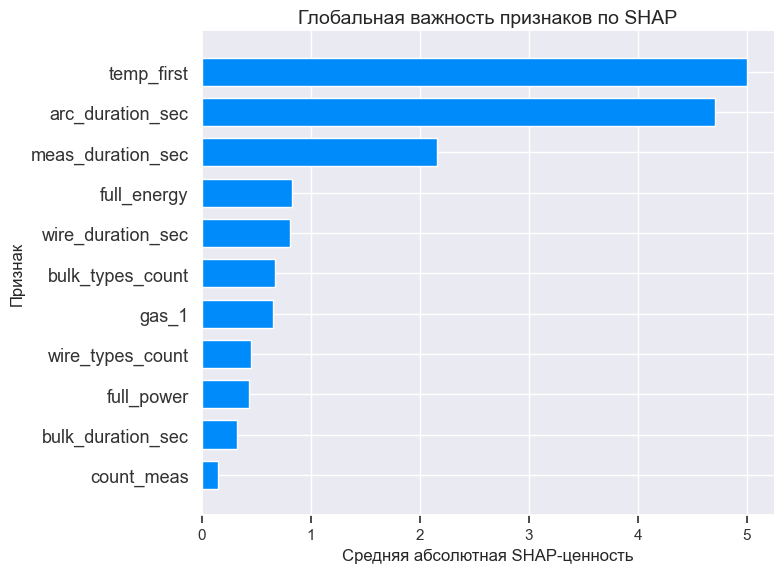

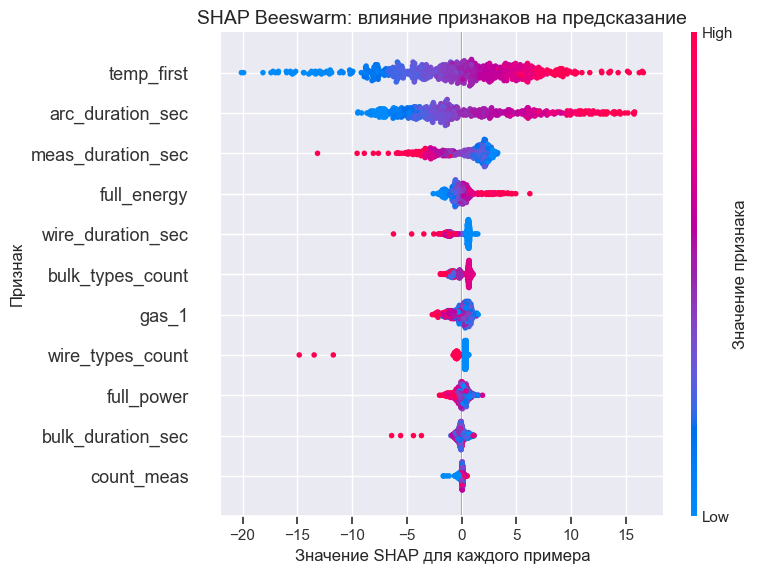

In [138]:
# оценим важность признаков с помощью SHAP
shap_values = best_cat.get_feature_importance(
    Pool(X_test_scaled, label=y_test),
    type='ShapValues'
)

shap_values = shap_values[:, :-1]

# график "bar" (глобальная важность)
shap.summary_plot(
    shap_values,
    features=X_test_scaled,
    feature_names=X_test_scaled.columns,
    plot_type='bar',
    show=False
)
plt.title('Глобальная важность признаков по SHAP', fontsize=14)
plt.xlabel('Средняя абсолютная SHAP-ценность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.tight_layout()
plt.show()

# график "beeswarm"
shap.summary_plot(
    shap_values,
    features=X_test_scaled,
    feature_names=X_test_scaled.columns,
    plot_type='dot',
    color_bar_label='Значение признака',
    show=False
)
plt.title('SHAP Beeswarm: влияние признаков на предсказание', fontsize=14)
plt.xlabel('Значение SHAP для каждого примера', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.tight_layout()
plt.show()


**Вывод:** наилучшая модель (CatBoost) на тестовой выборке показала результат 6.6912. Целевая метрика достигнута. Наиболее важными признаками оказались `temp_first`, `arc_duration_sec`, `meas_duration_sec`.

## 8. Общий вывод и рекомендации заказчику

**В ходе работы над проектом выполнена следующие задачи:**
* Загрузка и первичный анализ всех предоставленных датасетов (7 источников)
* Предобработка данных, в частности обработка пропущенных значений, преобразование временных признаков.
* Объединение всех источников данных в единый датафрейм.
* Произведен отбор признаков, устранены признаки с высокой корреляцией.
* Выполнено масштабирование признаков.
* Обучение 4 моделей МО сподбором гиперпараметров с помощью RandomizedSearch: LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor.
* Выбрана наилучшая модель (RandomForestRegressor) и проверена ее качетсво на тестовой выборке (целевая метрика достигнута).
* Оценена важность признаков.

**Среди трудностей можно отметить:**
* Множество пропущенных значений в data_bulk, data_bulk_time, data_wire, data_wire_time. Пропущенные значения интерпретированы как отсутствие компонента и заполнены нулями.
* Высокая корреляция между признаками. Выполнен отбор признаков и удаление избыточных.

**Ключевыми шагами в решении являлись:**
* Выделение новых признаков на основе первичных данных.
* Отбор признаков для обучение моделей МО.
* Использование кросс-валидации и подбора гиперпараметров для выбора наилучшей модели.

**Список признаков, используемых для обучения лучшей модели и описание их предобработки**
* `arc_duration_sec` — длительность дуги
* `full_energy` — суммарная энергия
* `full_power` — суммарная мощность
* `bulk_duration_sec` — длительность подачи метриалов (рассчитано на основании data_bulk_time)
* `bulk_types_count` — число типов материалов (рассчитано на основании data_bulk_time)
* `gas_1` — объем газа
* `temp_first` — первая температура
* `temp_last` — последняя температура (целевой признак)
* `count_meas` — число температурных измерений
* `meas_duration_sec` — длительность измерений
* `wire_duration_sec` — длительность подачи проволочных материалов (рассчитано на основании data_wire_time)
* `wire_types_count` — число типов проволочных материалов (рассчитано на основании data_wire_time)

**Гиперпараметры лучшей модели**
* CatBoost
* learning_rate: 0.1
* l2_leaf_reg: 7
* iterations: 200
* depth: 6
* random_strength: 1
* bagging_temperature: 0.5.
* random_state - RANDOM_STATE(50525)
* Целевая метрика (MAE) на тестовой выборке составила 6.6912 (по условиям задачи < 6.8)

**Рекомендации для улучшения модели**
* Более глубокий анализ временных зависимостей между bulk/wire/temp событиями.
* Возможена генерация новых признаков.

**Рекомендации для бизнеса**
* Модель выявила, что на итоговую температуру наиболее сильно влияют: длительность дуги (arc_duration_sec), первая температура (temp_first), длительность измерений (meas_duration_sec). Можно сосредоточиться на стандартизации и управлении этими параметрами при производстве для более стабильных результатов.
* Большая длительность операций (например, подачи дуги) влияет на температуру, однако чрезмерные значения могут привести к нестабильности. Можно установить допустимые диапазоны для длительности процессов и внедрить систему раннего оповещения об отклонениях от нормы.
* Поскольку модель обеспечивает высокую точность предсказания температуры, её можно интегрировать в производственный цикл: внедрить модуль прогнозирования температуры до окончания плавки для динамической корректировки параметров и предотвращения брака.

**Общий вывод:** была проведена полная цепочка работ по решению регрессионной задачи: от анализа и обработки данных до построения моделей и оценки их качества.
Лучшая модель — CatBoost — показала метрику, соответствующую заданному ограничению (MAE < 6.8). Были выделены важнейшие признаки и даны рекомендации заказчику.